# imports

In [1]:
import torch
torch.cuda.set_device(7)
if torch.cuda.is_available():
    current_gpu = torch.cuda.current_device()
    print(f"Current default GPU index: {current_gpu}")
    print(f"Current default GPU name: {torch.cuda.get_device_name(current_gpu)}")
else:
    print("No GPUs available.")

Current default GPU index: 7
Current default GPU name: NVIDIA A40


In [2]:
import os


def count_txt_files(folder_path):
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        print("The specified folder does not exist.")
        return 0
    
    # List all files in the directory
    files = os.listdir(folder_path)
    
    # Filter and count files that end with .txt
    txt_files_count = sum(1 for file in files if file.endswith('.txt'))
    
    return txt_files_count
def count_png_files(folder_path):
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        print("The specified folder does not exist.")
        return 0
    
    # List all files in the directory
    files = os.listdir(folder_path)
    
    # Filter and count files that end with .txt
    txt_files_count = sum(1 for file in files if file.endswith('.png'))
    
    return txt_files_count


In [3]:
import os
import time

def wait_for_files(directory, target_count=40):
    """
    Continuously checks the directory until it contains at least target_count .txt files.

    Args:
    directory (str): The path to the directory to check.
    target_count (int): The minimum number of .txt files desired in the directory.
    """
    while True:
        count = count_txt_files(directory)
        print(f"Checking... There are currently {count} .txt files.")
        if count >= target_count:
            print(f"Reached target of {target_count} .txt files.")
            time.sleep(500)
            break
        time.sleep(20)  # Wait for 10 seconds before checking again

# # Example usage
# directory_path = 'saved_data/cifar_train500_2syn_i2i/'
# wait_for_files(directory_path)

In [4]:
# all imports

# buffer
from collections import defaultdict
import random
from abc import ABC, abstractmethod
from typing import (
    Any,
    Dict,
    Generic,
    Optional,
    List,
    TYPE_CHECKING,
    Set,
    TypeVar,
)

from avalanche.benchmarks.utils import (
    classification_subset,
    AvalancheDataset,
)
from avalanche.models import FeatureExtractorBackbone
# from ..benchmarks.utils.utils import concat_datasets
from avalanche.benchmarks.utils import concat_datasets
from avalanche.training.storage_policy import ReservoirSamplingBuffer, BalancedExemplarsBuffer, ClassBalancedBuffer

from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy, ExemplarsBuffer, ExperienceBalancedBuffer
from avalanche.benchmarks.utils.data_loader import ReplayDataLoader
from avalanche.training.plugins import SupervisedPlugin
from typing import Optional, TYPE_CHECKING

from avalanche.benchmarks.utils import concat_classification_datasets
from avalanche.training.plugins.strategy_plugin import SupervisedPlugin

if TYPE_CHECKING:
    from avalanche.training.templates import SupervisedTemplate, BaseSGDTemplate

# dataset
from avalanche.benchmarks import SplitMNIST, SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR10
from avalanche.benchmarks.utils.data_loader import GroupBalancedDataLoader, ReplayDataLoader
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark, \
                                            tensors_benchmark, paths_benchmark

from avalanche.logging import InteractiveLogger, TensorboardLogger, \
    WandBLogger, TextLogger, TensorboardLogger

from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, loss_metrics

from avalanche.training.plugins.checkpoint import CheckpointPlugin, \
    FileSystemCheckpointStorage
from avalanche.training.determinism.rng_manager import RNGManager
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1
from avalanche.models import SimpleMLP
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1
from avalanche.models import SimpleMLP
from avalanche.training.plugins import ReplayPlugin
from types import SimpleNamespace
from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import inf

In [6]:
# all imports

import torch
import os
from torch import cat, Tensor
from torch.nn import Module
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset, ConcatDataset, TensorDataset
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import datasets, transforms
import torch.optim.lr_scheduler # ?
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, CenterCrop, RandomHorizontalFlip, Resize
from torchvision.transforms.functional import center_crop
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.utils import save_image
from torchvision.transforms.functional import pil_to_tensor


In [7]:
from typing import Iterable, Sequence, Optional, Union, List
from pkg_resources import parse_version

import torch
from torch.nn import Module, CrossEntropyLoss
from torch.optim import Optimizer
from torch.utils.data import DataLoader

from avalanche.benchmarks import CLExperience, CLStream
from avalanche.core import BaseSGDPlugin
from avalanche.training.plugins import SupervisedPlugin, EvaluationPlugin
from avalanche.training.plugins.clock import Clock
from avalanche.training.plugins.evaluation import default_evaluator
from avalanche.training.templates.base import BaseTemplate, ExpSequence
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.benchmarks.utils.data_loader import TaskBalancedDataLoader, \
    collate_from_data_or_kwargs
from avalanche.training.utils import trigger_plugins

In [8]:
# import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import os

stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

transform = transform_train = Compose([
    Resize(196),
    # Resize(384),
    # RandomHorizontalFlip(),
    ToTensor(),
    # Normalize(*stats,inplace=True)
])

# Load the CIFAR-100 training set
trainset = torchvision.datasets.CIFAR100(root='data', train=True,
                                         download=True, transform=transform)

name_list = trainset.classes

Files already downloaded and verified


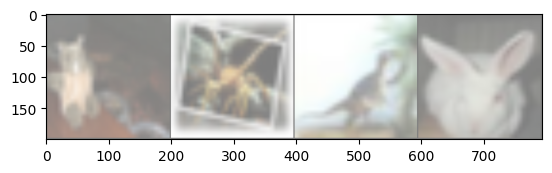

possum lobster dinosaur rabbit


In [9]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if Normalize was used in transform
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(4)))


In [10]:

def tensor_to_pil(image_tensor):
    return transforms.ToPILImage()(image_tensor).convert("RGB")

In [11]:
import os
import torch
import torchvision
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ToTensor
from torchvision.utils import save_image


def save_cifar100_random_replay(dataset, num_images_per_class, save_dir):
	if not os.path.exists(save_dir):
		os.makedirs(save_dir)
	torch.manual_seed(41)

	saved_counts = {label: 0 for label in range(100)}  # Initialize saved image count for each class

	transform_to_tensor = transforms.ToTensor()

	indices = torch.randperm(len(dataset)).tolist()
	for idx in indices:
		image, label = dataset[idx]

		# Check if image is already a tensor, transform if not
		if not isinstance(image, torch.Tensor):
			image_tensor = transform_to_tensor(image)
		else:
			image_tensor = image  # Use the image directly if it is already a tensor

		# Skip saving if this class already has the desired number of images saved
		if saved_counts[label] >= num_images_per_class:
			continue

		class_name = dataset.classes[label]
		image_path = os.path.join(save_dir, f'{class_name}{saved_counts[label]}.png')
		save_image(image_tensor, image_path)
		saved_counts[label] += 1

		# Check if we have finished saving max_images for all classes
		class_file_path = os.path.join(save_dir, f"class{label}.txt")
		with open(class_file_path, "a") as file:
			file.write(f"{image_path} {label}\n")

		# Check if we have finished saving the specified number of images for all classes
		if all(count >= num_images_per_class for count in saved_counts.values()):
			break
# 		if saved_counts[1] < num_images_per_class:
# 			print('not enough data', saved_counts[1])
	print(f"Saved {num_images_per_class} images per class from the CIFAR-100 training dataset.")


integer_to_name = {i: name for i, name in enumerate(name_list)}

import os
import torch
from torchvision import transforms
from torchvision.utils import save_image

def save_specific_cifar100(dataset, num_images_per_class, save_dir, real_list):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    torch.manual_seed(41)

    saved_counts = {label: 0 for label in range(100)}  # Initialize saved image count for each class

    transform_to_tensor = transforms.ToTensor()

    indices = torch.randperm(len(dataset)).tolist()
    
    for idx in indices:
        image, label = dataset[idx]
        
        if label in real_list:
            # Check if image is already a tensor, transform if not
            if not isinstance(image, torch.Tensor):
                image_tensor = transform_to_tensor(image)
            else:
                image_tensor = image  # Use the image directly if it is already a tensor

            # Skip saving if this class already has the desired number of images saved
            if saved_counts[label] >= num_images_per_class:
                continue

            class_name = dataset.classes[label]
            image_path = os.path.join(save_dir, f'{class_name}{saved_counts[label]}.png')
            save_image(image_tensor, image_path)
            saved_counts[label] += 1

            # Save path to file
            class_file_path = os.path.join(save_dir, f"class{label}.txt")
            with open(class_file_path, "a") as file:
                file.write(f"{image_path} {label}\n")

            # Check if we have finished saving the specified number of images for all classes
            if all(count >= num_images_per_class for count in saved_counts.values()):
                break

    print(f"Saved {num_images_per_class} images per class from the CIFAR-100 training dataset.")


def combine_files_with_numbers(folder, file_initial, numbers, output_folder):
    """use to get the data with label in the training experience"""
    combined_content = ""  # Initialize an empty string to store combined content
    # Compile a set of filenames to look for, based on the list of numbers
    filenames_to_look_for = {file_initial + f"{number}.txt" for number in numbers}
    print(filenames_to_look_for)
    
    os.makedirs(output_folder, exist_ok=True)

    # Iterate over each file in the specified folder
#     files_found = 0
    
    for file in os.listdir(folder):
        # Check if the file name matches exactly any in our set of filenames to look for
        if file in filenames_to_look_for:
#             print(f'found file {file}')
            # Open and read the file, then add its content to the combined_content string
            with open(os.path.join(folder, file), 'r') as f:
                combined_content += f.read()  # Add a newline character after each file's content for better separation
#                 print(combined_content)

    joined_string = '_'.join(str(integer) for integer in numbers)


    output_file_path = os.path.join(output_folder, f"{file_initial}combined_{joined_string}.txt")
    print(output_file_path)
    with open(output_file_path, 'w') as f:
        f.write(combined_content)

        
def combine_files_with_numbers_toawhole(folder, file_initial, numbers, output_folder):
    combined_content = ""  # Initialize an empty string to store combined content
    # Compile a set of filenames to look for, based on the list of numbers
    filenames_to_look_for = {file_initial + f"{number}.txt" for number in numbers}
    print(filenames_to_look_for)
    
    os.makedirs(output_folder, exist_ok=True)

    # Iterate over each file in the specified folder
#     files_found = 0
    
    for file in os.listdir(folder):
        # Check if the file name matches exactly any in our set of filenames to look for
        if file in filenames_to_look_for:
#             print(f'found file {file}')
            # Open and read the file, then add its content to the combined_content string
            with open(os.path.join(folder, file), 'r') as f:
                combined_content += f.read()  # Add a newline character after each file's content for better separation
#                 print(combined_content)

    output_file_path = os.path.join(output_folder, f"{file_initial}_combined_alltogether.txt")
    print(output_file_path)
    with open(output_file_path, 'w') as f:
        f.write(combined_content)

In [12]:
# sythnthesis classes
benchmark = SplitCIFAR100(n_experiences=20,
                          seed = 41,             
                          )

orders = benchmark.classes_order
order_list = [orders[x:x+5] for x in range(0, len(orders), 5)]

order_sample = [order[3:] for order in order_list]
order_sample_real = [order[:3] for order in order_list]
classname_list = []
label_list = []
classname_list_sep = []
for order_l in order_sample:
    label_list.append(order_l)
    cur_classname = [integer_to_name[i] for i in order_l]
    classname_list.append(cur_classname)
classname_list_sep = [item for lists in classname_list for item in lists]
label_list_sep = [item for lists in label_list for item in lists]
print(label_list_sep)

real_list = set([i for i in range(100)]) - set(label_list_sep)


Files already downloaded and verified
Files already downloaded and verified
[5, 20, 83, 19, 62, 33, 74, 53, 4, 32, 40, 41, 64, 21, 49, 68, 65, 46, 72, 31, 8, 1, 18, 86, 85, 95, 25, 82, 66, 37, 78, 52, 3, 99, 28, 90, 17, 77, 79, 58]


In [13]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.layers(x)


## mlp estimation

In [14]:
import torch.nn as nn
class DINOFeatureExtractor_v2(nn.Module):
    def __init__(self):
        super().__init__()
        # Load the pre-trained DINO model
        # self.feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        self.feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
        # self.feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
        # self.feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg')

        
        # Remove the head or adapt it to return features instead of logits
        self.feature_extractor.fc = nn.Identity()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Extract features using the DINO backbone
        return self.feature_extractor(x)

In [15]:
from torch.utils.data import DataLoader, TensorDataset
from torchvision.io import read_image

def load_and_transform_images(image_paths_file):
    # Define the image transformations
    transform_to_tensor = transforms.ToTensor()
    
    transform = Compose([
    
    Resize(196),
    # ToTensor(),
    Normalize(mean=[0.5071, 0.4866, 0.4410], std=[0.1941, 0.1917, 0.1957])])
    

    # Read image paths from the text file
    with open(image_paths_file, 'r') as file:
        image_paths = [line.split()[0] for line in file.readlines()]

    # Load images, apply transformations, and stack into a tensor
    # images = [transform(read_image(path).to(torch.float32)) for path in image_paths]
    # img = Image.open(path).convert('RGB')
    # img_tensor = transform_to_tensor(img)
    images = [transform(transform_to_tensor(Image.open(path).convert('RGB'))) for path in image_paths]
    
    batch_images = torch.stack(images)  # Stack images into a batch

    return batch_images



In [22]:
def extract_features(batch_images):
    # Assuming the feature_extractor is a PyTorch model loaded and moved to 'cuda' if available
    with torch.no_grad():  # No need to track gradients for feature extraction
        features = feature_extractor(batch_images.to('cuda')).to('cpu')  # Ensure images are on the same device as the model
    return features

def process_extractfeatures_images_from_files(file_path1, file_path2):
    # Load and transform images from each file
    batch_imagesx = load_and_transform_images(file_path1)
    batch_imagesy = load_and_transform_images(file_path2)

    features_x = extract_features(batch_imagesx)
    features_y = extract_features(batch_imagesy)

    return features_x, features_y

def l2_normalize(features):
    # Compute the L2 norm for each row (dim=1)
    norms = torch.norm(features, p=2, dim=1, keepdim=True)
    # Divide each element by its norm
    normalized_features = features / norms
    return normalized_features

In [17]:
def prepare_data_loader(features_x, features_y, batch_size=32):
    # Create a dataset from the extracted features
    dataset = TensorDataset(features_x, features_y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader


In [18]:
order_real = [order[:3] for order in order_list]

In [19]:
# x_folder = '/scratch/local/ssd/enbo/saved_data/sdxl_llava_realfromreal_s5g2'
# y_folder = 'saved_data/cifar_train_all_fortest'

# syn = {}
# real = {}
# feature_extractor = DINOFeatureExtractor_v2().to('cuda')


In [20]:
## create txt files for dataset generation

# for i, t_class in enumerate(order_real):
#     combine_files_with_numbers(x_folder, 
#                                'class', 
#                                t_class, 
#                                x_folder + '_X/') # create txt files for x and y
#     combine_files_with_numbers(y_folder, 
#                                'class', 
#                                t_class, 
#                                y_folder + '_Y/')
#     joined_string = '_'.join(str(integer) for integer in t_class)
#     # output_folder = destination_folder + '_combined/'
#     file_initial = 'class'
#     output_x = x_folder + '_X/' +file_initial+ 'combined' + '_' + joined_string + '.txt' 
#     output_y = y_folder + '_Y/' +file_initial+ 'combined' + '_' + joined_string + '.txt' 
    
#     all_x, all_y = process_extractfeatures_images_from_files(output_x, output_y)
#     syn[i] = all_x
#     real[i] = all_y
    

In [23]:
# torch.save(syn, 'saved_data/featurex_realfromreal_s5g2.pth')
# torch.save(real, 'saved_data/featurey_real.pth')
syn = torch.load('saved_data/featurex_realfromreal_s5g2.pth')
real = torch.load('saved_data/featurey_real.pth')

In [24]:
all_x = torch.cat([syn[i] for i in sorted(syn.keys())], dim=0)
all_y = torch.cat([real[i] for i in sorted(real.keys())], dim=0)

In [25]:
all_x, all_y = l2_normalize(all_x), l2_normalize(all_y)

In [26]:
all_x.shape

torch.Size([30000, 1024])

In [40]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim

# Assuming all_x and all_y are your datasets loaded into tensors
dataset = TensorDataset(all_x, all_y)

# Calculate split sizes
test_size = int(0.1 * len(dataset))  # 10% of the dataset
train_size = len(dataset) - test_size  # Remaining 90% for training

# Randomly split the dataset into training and test datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for both datasets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model setup
input_size = 1024
hidden_size = 512
output_size = 1024
model = MLP(input_size, hidden_size, output_size).to('cuda')

# Loss function and optimizer
criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
# Training the model
num_epochs =8
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
    
    epoch_loss = total_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')

    # Optionally, evaluate the model on the test set after each epoch
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
        test_loss /= len(test_dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}')
    model.train()  # Set the model back to training mode


Epoch [1/8], Training Loss: 0.0213
Epoch [1/8], Test Loss: 0.0203
Epoch [2/8], Training Loss: 0.0200
Epoch [2/8], Test Loss: 0.0201
Epoch [3/8], Training Loss: 0.0197
Epoch [3/8], Test Loss: 0.0200
Epoch [4/8], Training Loss: 0.0194
Epoch [4/8], Test Loss: 0.0200
Epoch [5/8], Training Loss: 0.0193
Epoch [5/8], Test Loss: 0.0200
Epoch [6/8], Training Loss: 0.0191
Epoch [6/8], Test Loss: 0.0201
Epoch [7/8], Training Loss: 0.0189
Epoch [7/8], Test Loss: 0.0201
Epoch [8/8], Training Loss: 0.0188
Epoch [8/8], Test Loss: 0.0201


In [42]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Example: Save the model
model_path = "saved_model/syntheticreal_synthetic_mlp_b64_512_8_prenorm.pth"
save_model(model, model_path)


def load_model(model_path, input_size, hidden_size, output_size):
    model = MLP(input_size, hidden_size, output_size)  # Re-create the model architecture
    model.load_state_dict(torch.load(model_path))  # Load the saved state dictionary
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {model_path}")
    return model


Model saved to saved_model/syntheticreal_synthetic_mlp_b64_512_8_prenorm.pth


In [188]:
# Example: Load the model
# loaded_model = load_model(model_path, 1024, 128, 1024)


## end mlp estimation

In [43]:
def map_features(model, features):
    model.to('cuda')
    with torch.no_grad():  # Ensure no gradients are computed
        mapped_features = model(features.to('cuda'))  # Assuming features and model are on the same device
    return mapped_features

# # Example: Map features using the loaded model
sample_features = torch.randn(1, 1024).to('cuda')  # Create a dummy feature tensor
# mapped_features = map_features(loaded_model, sample_features)
# print("Mapped Features:", mapped_features.shape)


In [44]:
import torch

def load_model(model_path, input_size, hidden_size, output_size):
    model = MLP(input_size, hidden_size, output_size)  # Re-create the model architecture
    model.load_state_dict(torch.load(model_path))  # Load the saved state dictionary
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {model_path}")
    return model
# Load the saved dictionary of tensors
# matrices_A1 = torch.load('saved_data/transform_matrix_s5g2_2.pth')
# matrices_A = torch.load('saved_data/transform_matrix_s5g2_3.pth')
model_path = "saved_model/syntheticreal_synthetic_mlp_b64_512_8_prenorm.pth"
loaded_model = load_model(model_path, 1024, 512, 1024)


Model loaded from saved_model/syntheticreal_synthetic_mlp_b64_512_8_prenorm.pth


In [45]:
# output_folder = 'saved_data/real_sythesis_cifar100_llava'
# output_folder= '/scratch/local/ssd/enbo/saved_data/sdxl_llava_synfromreal_text2image'
# output_folder = 'saved_data/sdxl_llava_synfromreal_s8g2'
output_folder = 'saved_data/real_sythesis_cifar100_llava_i2i_3real_2'
# output_folder = '/scratch/local/ssd/enbo/saved_data/sdxl_llava_realfromreal_s5g2'
# output_folder = 'saved_data/sdxl_llava_synfromreal_expsim'
# output_folder = '/scratch/local/ssd/enbo/saved_data/synreal_realsyn_714_estimatecorrectness_2'
# output_folder = '/scratch/local/ssd/enbo/saved_data/text1folder'
count = count_txt_files(output_folder)
print(f"There are {count} .txt files in the folder.")
count = count_png_files(output_folder)
print(f"There are {count} .png files in the folder.")

There are 100 .txt files in the folder.
There are 50000 .png files in the folder.


In [46]:
# save_cifar100_random_replay(testset, 100, 'saved_data/cifar_test100')

In [47]:
trainset = torchvision.datasets.CIFAR100(root='data', train=True,
                                         download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='data', train=False,
                                         download=True, transform=transform)
name_list = trainset.classes

integer_to_name = {i: name for i, name in enumerate(name_list)}
name_to_integer = {name: i for i, name in enumerate(name_list)}

Files already downloaded and verified
Files already downloaded and verified


In [48]:
import json

def save_dict_to_json(data_dict, file_path):
    with open(file_path, 'w') as file:
        json.dump(data_dict, file)
# save_dict_to_json(name_to_integer, 'saved_data/cifar100_name2integer.json')

def load_dict_from_json(file_path):
    with open(file_path, 'r') as file:
        data_dict = json.load(file)
    return data_dict

# # Example usage
# loaded_dict = load_dict_from_json('my_dictionary.json')
# print(loaded_dict)

In [49]:
import os
import shutil

def filter_class_txt_files_from1to1(folder_path, output_folder, specific_dict_integer_to_name, folder_path2 = None):
    """
    Filters out images and text files for specified classes and copies them to a new directory.

    Args:
    image_folder (str): Path to the directory containing images.
    txt_folder (str): Path to the directory containing text files.
    output_folder (str): Path to the directory where filtered files should be stored.
    class_list (list): List of class numbers as strings.
    """
    # Ensure output directory exists
    
    class_numbers = list(specific_dict_integer_to_name.keys())
    class_names = list(specific_dict_integer_to_name.values())
        
    
    os.makedirs(output_folder, exist_ok=True)
    if not folder_path2:
        file_list = os.listdir(folder_path)
    else:
        file_list = os.listdir(folder_path) + os.listdir(folder_path2)

    for file in file_list:
        # Check if the file is an image or a text file for the classes in the list
        if (file.endswith('.txt') and int(file.split('class')[1].split('.txt')[0]) in class_numbers):
            # Copy file to output directory
            if file in os.listdir(folder_path):
                shutil.copy(os.path.join(folder_path, file), os.path.join(output_folder, file))
            else:
                shutil.copy(os.path.join(folder_path2, file), os.path.join(output_folder, file))



In [50]:
import os
import shutil

def filter_class_txt_files_from2to1(folder_path1, folder_path2, output_folder, specific_dict1, specific_dict2):
    """
    Filters out text files for specified classes from two directories and copies them to a new directory.

    Args:
    folder_path1 (str): Path to the first directory containing text files.
    folder_path2 (str): Path to the second directory containing text files.
    output_folder (str): Path to the directory where filtered files should be stored.
    specific_dict1 (dict): Dictionary where keys are class numbers and values are class names for the first directory.
    specific_dict2 (dict): Dictionary where keys are class numbers and values are class names for the second directory.
    """
    # Ensure output directory exists
    os.makedirs(output_folder, exist_ok=True)

    # Combine both dictionaries for easier processing
    combined_dict = {**specific_dict1, **specific_dict2}

    # Get the list of files from both directories
    file_list1 = os.listdir(folder_path1)
    file_list2 = os.listdir(folder_path2)

    # Process files in the first folder
    for file in file_list1:
        if file.endswith('.txt'):
            try:
                class_number = int(file.split('class')[1].split('.txt')[0])
                if class_number in specific_dict1:
                    shutil.copy(os.path.join(folder_path1, file), os.path.join(output_folder, file))
            except (IndexError, ValueError):
                # Handle cases where file name format doesn't match the expected pattern
                continue

    # Process files in the second folder
    for file in file_list2:
        if file.endswith('.txt'):
            try:
                class_number = int(file.split('class')[1].split('.txt')[0])
                if class_number in specific_dict2:
                    shutil.copy(os.path.join(folder_path2, file), os.path.join(output_folder, file))
            except (IndexError, ValueError):
                # Handle cases where file name format doesn't match the expected pattern
                continue

In [30]:
syn_dict = {class_number: integer_to_name[class_number] for class_number in label_list_sep if class_number in integer_to_name}
real_dict = {class_number: integer_to_name[class_number] for class_number in real_list if class_number in integer_to_name}

In [21]:

# Example usage'

filter_class_txt_files_from2to1(
                                '/scratch/local/ssd/enbo/saved_data/sdxl_llava_realfromreal_s5g2',
                                '/scratch/local/ssd/enbo/saved_data/sdxl_llava_i2i_10percentimageprompt',
                                '/scratch/local/ssd/enbo/saved_data/synreal_realsyns5g2_synsyn10percenti2is5g2', 
                                real_dict, 
                                syn_dict)


In [29]:
# filter_class_txt_files('saved_data/cifar_train_all_fortest', 
#                        '/scratch/local/ssd/enbo/saved_data/text1folder', 
#                        real_dict, folder_path2 = None)

In [30]:
# Example usage
# folder_path = 'saved_data/sd_turbo_500images_llava_firstthreeclasses'
# folder_path2 = 'saved_data/sd_turbo_500images_llava'
# output_folder = 'saved_data/sdxl_llava_synfromreal_s8g2'


# filter_class_txt_files(folder_path, output_folder, syn_dict, folder_path2)


In [31]:
output_folder = '/scratch/local/ssd/enbo/saved_data/synreal_realsyns5g2_synsyn10percenti2is5g2'
count = count_txt_files(output_folder)
print(f"There are {count} .txt files in the folder.")
count = count_png_files(output_folder)
print(f"There are {count} .png files in the folder.")

There are 100 .txt files in the folder.
There are 0 .png files in the folder.


In [32]:
def read_lines_from_file(file_path):
    """
    Reads and prints lines from a text file at the given path.

    Args:
    file_path (str): Path to the text file.
    """
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                print(line.strip())
    except FileNotFoundError:
        print(f"The file at {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# # Example usage
# # file_path = os.path.join(output_folder, 'class5.txt')
# file_path = '/scratch/local/ssd/enbo/saved_data/text1folder_combined/classcombined_36_0_54_5_20.txt'
# read_lines_from_file(file_path)


## dataset concate

## dataset prepare

In [51]:

import shutil
import os


# combine the real and sythesis data
# folder1 = 'saved_data/cifar99real_1synthetic'
# folder2 = 'saved_data/worm99_500'
# destination_folder = '/scratch/local/ssd/enbo/saved_data/sdxl_llava_synfromreal_text2image'
# destination_folder = 'saved_data/sdxl_llava_synfromreal_s8g2'
# destination_folder = 'saved_data/cifar_train_all_fortest'
# destination_folder = 'saved_data/sdxl_llava_synfromreal_expsim_guidance6'
# destination_folder = '/scratch/local/ssd/enbo/saved_data/synreal_realsyn_714_estimatecorrectness_2'
# destination_folder = '/scratch/local/ssd/enbo/saved_data/text1folder'
# destination_folder = 'saved_data/real_sythesis_cifar100_llava_i2i_3real_2'
destination_folder = '/scratch/local/ssd/enbo/saved_data/synreal_real_synsyn10percenti2is5g2'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

def copy_contents(src, dst):
    for item in os.listdir(src):
        src_path = os.path.join(src, item)
        dst_path = os.path.join(dst, item)

        if os.path.isdir(src_path):
            if not os.path.exists(dst_path):
                os.makedirs(dst_path)
            copy_contents(src_path, dst_path)  # Recursively copy subdirectories
        else:
            shutil.copy2(src_path, dst_path)  # Copy files

# copy_contents(folder1, destination_folder)
# copy_contents(folder2, destination_folder)


train_experience_list = []
for l in order_list:
    combine_files_with_numbers(
                destination_folder,
                'class',
                l,
                destination_folder + '_combined/')
    
    joined_string = '_'.join(str(integer) for integer in l)
    output_folder = destination_folder + '_combined/'
    file_initial = 'class'
    output_file_path = output_folder +file_initial+ 'combined' + '_' + joined_string + '.txt' 
    train_experience_list.append(output_file_path)


{'class5.txt', 'class20.txt', 'class54.txt', 'class0.txt', 'class36.txt'}
/scratch/local/ssd/enbo/saved_data/synreal_real_synsyn10percenti2is5g2_combined/classcombined_36_0_54_5_20.txt
{'class19.txt', 'class13.txt', 'class83.txt', 'class22.txt', 'class45.txt'}
/scratch/local/ssd/enbo/saved_data/synreal_real_synsyn10percenti2is5g2_combined/classcombined_22_45_13_83_19.txt
{'class62.txt', 'class73.txt', 'class26.txt', 'class33.txt', 'class16.txt'}
/scratch/local/ssd/enbo/saved_data/synreal_real_synsyn10percenti2is5g2_combined/classcombined_26_73_16_62_33.txt
{'class24.txt', 'class74.txt', 'class98.txt', 'class53.txt', 'class34.txt'}
/scratch/local/ssd/enbo/saved_data/synreal_real_synsyn10percenti2is5g2_combined/classcombined_34_98_24_74_53.txt
{'class4.txt', 'class10.txt', 'class32.txt', 'class94.txt', 'class51.txt'}
/scratch/local/ssd/enbo/saved_data/synreal_real_synsyn10percenti2is5g2_combined/classcombined_10_94_51_4_32.txt
{'class38.txt', 'class81.txt', 'class40.txt', 'class41.txt', 

In [52]:
import os

def list_first_ten_files(folder_path):
    """Prints the names of the first 10 files in the specified folder."""
    
    # Make sure the folder exists
    if not os.path.exists(folder_path):
        print("The specified folder does not exist.")
        return
    
    # List files in the directory
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    # Print the first 10 files
    for file in files[:10]:
        print(file)

# # Example usage:
# folder_path = "saved_data/real_sythesis_cifar100_llava_i2i_3real"
# list_first_ten_files(folder_path)


In [53]:
test_experience_list = []
for l in order_list:
    combine_files_with_numbers(
                'saved_data/cifar_test100',
                'class',
                l,
                'saved_data/cifar_test100' + '_combined/')
    
    joined_string = '_'.join(str(integer) for integer in l)
    output_folder = 'saved_data/cifar_test100' + '_combined/'
    file_initial = 'class'
    output_file_path = output_folder +file_initial+ 'combined' + '_' + joined_string + '.txt' 
    test_experience_list.append(output_file_path)


{'class5.txt', 'class20.txt', 'class54.txt', 'class0.txt', 'class36.txt'}
saved_data/cifar_test100_combined/classcombined_36_0_54_5_20.txt
{'class19.txt', 'class13.txt', 'class83.txt', 'class22.txt', 'class45.txt'}
saved_data/cifar_test100_combined/classcombined_22_45_13_83_19.txt
{'class62.txt', 'class73.txt', 'class26.txt', 'class33.txt', 'class16.txt'}
saved_data/cifar_test100_combined/classcombined_26_73_16_62_33.txt
{'class24.txt', 'class74.txt', 'class98.txt', 'class53.txt', 'class34.txt'}
saved_data/cifar_test100_combined/classcombined_34_98_24_74_53.txt
{'class4.txt', 'class10.txt', 'class32.txt', 'class94.txt', 'class51.txt'}
saved_data/cifar_test100_combined/classcombined_10_94_51_4_32.txt
{'class38.txt', 'class81.txt', 'class40.txt', 'class41.txt', 'class50.txt'}
saved_data/cifar_test100_combined/classcombined_38_81_50_40_41.txt
{'class30.txt', 'class69.txt', 'class21.txt', 'class89.txt', 'class64.txt'}
saved_data/cifar_test100_combined/classcombined_30_89_69_64_21.txt
{'cla

## create benchmark

In [54]:
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, Resize
import os
# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
transform_train = Compose([
    Resize(196),
    # RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=[0.5071, 0.4866, 0.4410], std=[0.1941, 0.1917, 0.1957])
    
])

transform_test = transform_train

# transform_test = Compose([
#     Resize(196),
#     ToTensor(),
#     Normalize(*stats,inplace=True)
# ])


In [55]:
sythesis_cifar_benchmark =  filelist_benchmark(
                                None,
                                train_file_lists = train_experience_list, # train
                                test_file_lists = test_experience_list, # test
                                task_labels = [0]*20,
                                # complete_test_set_only=True,
                                train_transform=transform_train,
                            eval_transform=transform_train
                            )

In [56]:
train_stream = sythesis_cifar_benchmark.train_stream
for experience in train_stream:
    t = experience.task_label
    exp_id = experience.current_experience
    training_dataset = experience.dataset
    print('Task {} batch {} -> train'.format(t, exp_id))
    print('This batch contains', len(training_dataset), 'patterns')
    print(f'This contains labels {experience.classes_in_this_experience}')

Task 0 batch 0 -> train
This batch contains 2500 patterns
This contains labels [0, 36, 5, 20, 54]
Task 0 batch 1 -> train
This batch contains 2500 patterns
This contains labels [45, 13, 19, 83, 22]
Task 0 batch 2 -> train
This batch contains 2500 patterns
This contains labels [33, 73, 16, 26, 62]
Task 0 batch 3 -> train
This batch contains 2500 patterns
This contains labels [98, 34, 74, 53, 24]
Task 0 batch 4 -> train
This batch contains 2500 patterns
This contains labels [32, 4, 10, 51, 94]
Task 0 batch 5 -> train
This batch contains 2500 patterns
This contains labels [38, 40, 41, 81, 50]
Task 0 batch 6 -> train
This batch contains 2500 patterns
This contains labels [64, 69, 21, 89, 30]
Task 0 batch 7 -> train
This batch contains 2500 patterns
This contains labels [68, 14, 49, 84, 88]
Task 0 batch 8 -> train
This batch contains 2500 patterns
This contains labels [65, 6, 46, 80, 57]
Task 0 batch 9 -> train
This batch contains 2500 patterns
This contains labels [72, 9, 48, 91, 31]
Task 

# Data transform

In [57]:
# !pip install pytorch_pretrained_vit


import torch
import matplotlib.pyplot as plt
import numpy as np
# ?

from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR10

from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark

from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark, \
                                            tensors_benchmark, paths_benchmark



In [58]:
# transform = transform_train = Compose([
#     Resize(196),
#     # Resize(384),
#     # RandomHorizontalFlip(),
#     ToTensor(),
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     Mean: tensor([0.5071, 0.4866, 0.4410])
# Standard Deviation: tensor([0.1941, 0.1917, 0.1957])
# ])

# attention

In [59]:
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
from avalanche.logging import InteractiveLogger, TensorboardLogger, \
    WandBLogger, TextLogger
# log to Tensorboard
tb_logger = TensorboardLogger()

# log to text file
text_logger = TextLogger(open('logs/synreal_real_synsyn10percenti2is5g2_mlp_prenorm.txt', 'w'))
# text_logger = TextLogger(open('logs/test.txt', 'a'))

# print to stdout
interactive_logger = InteractiveLogger()

In [60]:
# evaluation
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, loss_metrics, class_accuracy_metrics

# The evaluation plugin manages the metrics computation.
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    class_accuracy_metrics(minibatch=False, epoch=False, epoch_running=False, experience=False, stream=True),
    # forgetting_metrics(experience=True, stream=True),
    loggers=[interactive_logger, text_logger, tb_logger])

In [61]:
from avalanche.training.plugins.checkpoint import CheckpointPlugin, \
    FileSystemCheckpointStorage
from avalanche.training.determinism.rng_manager import RNGManager


In [62]:
RNGManager.set_random_seeds(1234)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

checkpoint_plugin = CheckpointPlugin(
    FileSystemCheckpointStorage(
        directory='./checkpoints/task_cifar',
    ),
    map_location=device
)

# Load checkpoint (if exists in the given storage)
# If it does not exist, strategy will be None and initial_exp will be 0
strategy, initial_exp = checkpoint_plugin.load_checkpoint_if_exists()

cuda


In [63]:
import os
import random

def combine_files_with_numbers(folder, file_initial, numbers, output_folder):
    """use to get the data with label in the training experience"""
    combined_content = ""  # Initialize an empty string to store combined content
    # Compile a set of filenames to look for, based on the list of numbers
    filenames_to_look_for = {file_initial + f"{number}.txt" for number in numbers}

    # Iterate over each file in the specified folder
    for file in os.listdir(folder):
        # Check if the file name matches exactly any in our set of filenames to look for
        if file in filenames_to_look_for:
            # Open and read the file, then add its content to the combined_content string
            with open(os.path.join(folder, file), 'r') as f:
                combined_content += f.read()  # Add a newline character after each file's content for better separation

    joined_string = '_'.join(str(integer) for integer in numbers)

    os.makedirs(output_folder, exist_ok=True)

    output_file_path = output_folder +file_initial+ 'combined' + '_' + joined_string + '.txt'
    print(output_file_path)
    with open(output_file_path, 'w') as f:
        f.write(combined_content)

def shuffle_text_file_lines(file_path):
    """
    Shuffles the lines in a text file.

    Parameters:
    - file_path: Path to the text file to shuffle.
    """
    # Read the lines from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Shuffle the lines
    random.shuffle(lines)

    # Write the shuffled lines back to the file
    with open(file_path, 'w') as file:
        file.writelines(lines)

# dino model

In [64]:
import torch.nn as nn
import torch
from avalanche.training.templates import SupervisedTemplate
from avalanche.benchmarks.utils import AvalancheDataset
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

import torch
from avalanche.training.plugins import SupervisedPlugin
from avalanche.benchmarks.utils.data_loader import ReplayDataLoader
from typing import Optional

class DINOFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # Load the pre-trained DINO model
        self.feature_extractor = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
        # Remove the head or adapt it to return features instead of logits
        self.feature_extractor.fc = nn.Identity()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Extract features using the DINO backbone
        return self.feature_extractor(x)
    
class DINOFeatureExtractor_v2(nn.Module):
    def __init__(self):
        super().__init__()
        # Load the pre-trained DINO model
        # self.feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        self.feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
        # self.feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
        # self.feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg')

        
        # Remove the head or adapt it to return features instead of logits
        self.feature_extractor.fc = nn.Identity()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Extract features using the DINO backbone
        return self.feature_extractor(x)

# KNN_DINO strategy

# experiment 20 tasks

In [65]:

# training
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1

# strategies
from avalanche.models import SimpleMLP
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

In [66]:
# training
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1

# strategies
from avalanche.models import SimpleMLP
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.training.plugins import ReplayPlugin

from types import SimpleNamespace

## dino knn

# update

In [67]:

class KNN_storagePlugin_update(SupervisedPlugin):

    def __init__(
        self,
        mem_size: int = 200,
        batch_size: int = None,
        batch_size_mem: int = None,
        task_balanced_dataloader: bool = False,
        storage_policy: Optional["ExemplarsBuffer"] = None,
    ):
        super().__init__()
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.batch_size_mem = batch_size_mem
        self.task_balanced_dataloader = task_balanced_dataloader

        if storage_policy is not None:  # Use other storage policy
            self.storage_policy = storage_policy
            assert storage_policy.max_size == self.mem_size
        else:  # Default
            self.storage_policy = ExperienceBalancedBuffer(
                max_size=self.mem_size, adaptive_size=True
            )
#         self.accuracy_metric = AccuracyMetric(task='multiclass')

    @property
    def ext_mem(self):
        return self.storage_policy.buffer_groups  # a Dict<task_id, Dataset>

    def before_training_exp(
        self,
        strategy: "SupervisedTemplate",
        num_workers: int = 0,
        shuffle: bool = True,
        **kwargs
    ):
        """
        Dataloader to build batches containing examples from both memories and
        the training dataset
        """
#         print('before_training_exp in plugin')

        if len(self.storage_policy.buffer) == 0:
            # first experience. We don't use the buffer, no need to change
            # the dataloader.
            buffer_size = len(self.storage_policy.buffer)
            print("buffer size: " + str(buffer_size))
            return

        batch_size = self.batch_size
        if batch_size is None:
            batch_size = strategy.train_mb_size

        batch_size_mem = self.batch_size_mem
        if batch_size_mem is None:
            batch_size_mem = strategy.train_mb_size
        strategy.dataloader = ReplayDataLoader(
            strategy.adapted_dataset,
            self.storage_policy.buffer,
            oversample_small_tasks=True,
            batch_size=batch_size,
            batch_size_mem=batch_size_mem,
            task_balanced_dataloader=self.task_balanced_dataloader,
            num_workers=num_workers,
            shuffle=shuffle,
        )
        buffer_size = len(self.storage_policy.buffer)
        print("buffer size: " + str(buffer_size))

    def after_training_exp(self, strategy: "SupervisedTemplate", **kwargs):
        self.storage_policy.update(strategy, **kwargs)
        buffer_size = len(self.storage_policy.buffer)
        print("after training exp buffer size: " + str(buffer_size))


import random
from abc import ABC, abstractmethod
from typing import Dict, Optional, List, TYPE_CHECKING

import torch
from numpy import inf
from torch import cat, Tensor
from torch.nn import Module
from torch.utils.data import DataLoader

from avalanche.benchmarks.utils import (
    make_classification_dataset,
    classification_subset,
    AvalancheDataset,
)
from avalanche.models import FeatureExtractorBackbone
# from ..benchmarks.utils.utils import concat_datasets

if TYPE_CHECKING:
    from .templates import SupervisedTemplate

class Custom_ParametricBuffer(BalancedExemplarsBuffer):
    """Stores samples for replay using a custom selection strategy and
    grouping."""

    def __init__(
        self,
        max_size: int,
        groupby=None,
        selection_strategy: Optional["ExemplarsSelectionStrategy"] = None,
    ):
        """Init.

        :param max_size: The max capacity of the replay memory.
        :param groupby: Grouping mechanism. One of {None, 'class', 'task',
            'experience'}.
        :param selection_strategy: The strategy used to select exemplars to
            keep in memory when cutting it off.
        """
        super().__init__(max_size)
        assert groupby in {None, "task", "class", "experience"}, (
            "Unknown grouping scheme. Must be one of {None, 'task', "
            "'class', 'experience'}"
        )
        self.groupby = groupby
        ss = selection_strategy or RandomExemplarsSelectionStrategy()
        self.selection_strategy = ss
        self.seen_groups = set()
        self._curr_strategy = None


    def update(self, strategy: "SupervisedTemplate", **kwargs):
        new_data = strategy.adapted_dataset
        new_groups = self._make_groups(strategy, new_data)
        self.seen_groups.update(new_groups.keys())

        # associate lengths to classes
        lens = self.get_group_lengths(len(self.seen_groups))
        group_to_len = {}
        for group_id, ll in zip(self.seen_groups, lens):
            group_to_len[group_id] = ll

        # update buffers with new data
        for group_id, new_data_g in new_groups.items():
            ll = group_to_len[group_id]
            if group_id in self.buffer_groups:
                old_buffer_g = self.buffer_groups[group_id]
                old_buffer_g.update_from_dataset(strategy, new_data_g)
                old_buffer_g.resize(strategy, ll)
            else:
                new_buffer = _ParametricSingleBuffer(
                    ll, self.selection_strategy
                )
                new_buffer.update_from_dataset(strategy, new_data_g)
                self.buffer_groups[group_id] = new_buffer

        # resize buffers
        for group_id, class_buf in self.buffer_groups.items():
            self.buffer_groups[group_id].resize(
                strategy, group_to_len[group_id]
            )

    def _make_groups(self, strategy, data):
        """Split the data by group according to `self.groupby`."""
        if self.groupby is None:
            return {0: data}
        elif self.groupby == "task":
            return self._split_by_task(data)
        elif self.groupby == "experience":
            return self._split_by_experience(strategy, data)
        elif self.groupby == "class":
            return self._split_by_class(data)
        else:
            assert False, "Invalid groupby key. Should never get here."

    def _split_by_class(self, data):
        # Get sample idxs per class
        class_idxs = {}
        for idx, target in enumerate(data.targets):
            if target not in class_idxs:
                class_idxs[target] = []
            class_idxs[target].append(idx)

        # Make AvalancheSubset per class
        new_groups = {}
        for c, c_idxs in class_idxs.items():
            new_groups[c] = classification_subset(data, indices=c_idxs)
        return new_groups

    def _split_by_experience(self, strategy, data):
        exp_id = strategy.clock.train_exp_counter + 1
        return {exp_id: data}

    def _split_by_task(self, data):
        new_groups = {}
        for task_id in data.task_set:
            new_groups[task_id] = data.task_set[task_id]
        return new_groups

class _ParametricSingleBuffer(ExemplarsBuffer):
    """A buffer that stores samples for replay using a custom selection
    strategy.

    This is a private class. Use `ParametricBalancedBuffer` with
    `groupby=None` to get the same behavior.
    """

    def __init__(
        self,
        max_size: int,
        selection_strategy: Optional["ExemplarsSelectionStrategy"] = None,
    ):
        """
        :param max_size: The max capacity of the replay memory.
        :param selection_strategy: The strategy used to select exemplars to
                                   keep in memory when cutting it off.
        """
        super().__init__(max_size)
        ss = selection_strategy or RandomExemplarsSelectionStrategy()
        self.selection_strategy = ss
        self._curr_strategy = None

    def update(self, strategy: "SupervisedTemplate", **kwargs):
        new_data = strategy.adapted_dataset
        self.update_from_dataset(strategy, new_data)

    def update_from_dataset(self, strategy, new_data):
        self.buffer = self.buffer.concat(new_data)
        self.resize(strategy, self.max_size)

    def resize(self, strategy, new_size: int):
        self.max_size = new_size
        idxs = self.selection_strategy.make_sorted_indices(
            strategy=strategy, data=self.buffer
        )
        self.buffer = self.buffer.subset(idxs[: self.max_size])

        
from avalanche.benchmarks.utils import make_classification_dataset

class KNN_DINO_update(BaseTemplate):
    """Base SGD class for continual learning skeletons.

    **Training loop**
    The training loop is organized as follows::

        train
            train_exp  # for each experience

    **Evaluation loop**
    The evaluation loop is organized as follows::

        eval
            eval_exp  # for each experience

    """

    PLUGIN_CLASS = BaseSGDPlugin

    def __init__(
        self,
        model: Module,
#         optimizer: Optimizer,
#         criterion=CrossEntropyLoss(),
        train_mb_size: int = 1,
        train_epochs: int = 1,
        eval_mb_size: Optional[int] = 1,
        device="cpu",
        plugins: Optional[List["SupervisedPlugin"]] = None,
        evaluator: EvaluationPlugin = default_evaluator(),
        eval_every=-1,
        peval_mode="epoch",
        k: int = 5,
        T: float = 0.07
    ):
        """Init.

        :param model: PyTorch model.
        :param optimizer: PyTorch optimizer.
        :param criterion: loss function.
        :param train_mb_size: mini-batch size for training.
        :param train_epochs: number of training epochs.
        :param eval_mb_size: mini-batch size for eval.
        :param evaluator: (optional) instance of EvaluationPlugin for logging
            and metric computations. None to remove logging.
        :param eval_every: the frequency of the calls to `eval` inside the
            training loop. -1 disables the evaluation. 0 means `eval` is called
            only at the end of the learning experience. Values >0 mean that
            `eval` is called every `eval_every` epochs and at the end of the
            learning experience.
        :param peval_mode: one of {'epoch', 'iteration'}. Decides whether the
            periodic evaluation during training should execute every
            `eval_every` epochs or iterations (Default='epoch').
        """
        super().__init__(model=model, device=device, plugins=plugins)

#         self.optimizer: Optimizer = optimizer
#         """ PyTorch optimizer. """

#         self._criterion = criterion
#         """ Criterion. """

        self.train_epochs: int = train_epochs
        """ Number of training epochs. """

        self.train_mb_size: int = train_mb_size
        """ Training mini-batch size. """

        self.eval_mb_size: int = (
            train_mb_size if eval_mb_size is None else eval_mb_size
        )
        """ Eval mini-batch size. """

        if evaluator is None:
            evaluator = EvaluationPlugin()
        self.plugins.append(evaluator)
        self.evaluator = evaluator
        assert peval_mode in {"experience", "epoch", "iteration"}
        self.eval_every = eval_every
#         peval = PeriodicEval(eval_every, peval_mode)
#         self.plugins.append(peval)

        self.clock = Clock()
        """ Incremental counters for strategy events. """
        self.plugins.append(self.clock)

        self.adapted_dataset = None
        """ Data used to train. It may be modified by plugins. Plugins can 
        append data to it (e.g. for replay). 

        .. note::

            This dataset may contain samples from different experiences. If you 
            want the original data for the current experience  
            use :attr:`.BaseTemplate.experience`.
        """
        self.model = model
        self.dataloader = None
        self.mbatch = None
        self.mb_output = None
        self.loss = None
        self._stop_training = False
        self.k = k
        self.T = T
        self.train_features = None
        self.train_labels = None
        self.replay_plugin = plugins[0]

    @torch.no_grad()
    def train(self,
              experiences: Union[CLExperience,
                                 ExpSequence],
              eval_streams: Optional[Sequence[Union[CLExperience,
                                                    ExpSequence]]] = None,
              **kwargs):

#         super().train(experiences, eval_streams, **kwargs)
#         return self.evaluator.get_last_metrics()
        self.is_training = True
        self._stop_training = False

        self.model.eval()  # Feature extraction mode, so we set the model to eval
        self.model.to(self.device)
        with torch.no_grad():
            if not isinstance(experiences, Iterable):
                experiences = [experiences]
            if eval_streams is None:
                eval_streams = [experiences]
            self._eval_streams = _group_experiences_by_stream(eval_streams)

            self._before_training(**kwargs)
            
            for self.experience in experiences:
                self._before_training_exp(**kwargs)
                self._train_exp(experience, **kwargs)
                self._after_training_exp(**kwargs)
            self._after_training(**kwargs)
                
                
                
    def forward(self):
        """Compute the model's output given the current mini-batch."""
#         raise NotImplementedError()
        if self.mb_x is not None:
            return self.model(self.mb_x.to(self.device))  # Ensure device compatibility
        else:
            raise ValueError("Input data not loaded: self.mb_x is None")

    def _before_training_exp(self, **kwargs):
        """Setup to train on a single experience."""
        print('_before_training_exp in strategy')
        # Data Adaptation (e.g. add new samples/data augmentation)
        self._before_train_dataset_adaptation(**kwargs)
        self.train_dataset_adaptation(**kwargs)
        self._after_train_dataset_adaptation(**kwargs)
#         trigger_plugins(self, "before_training_exp", **kwargs)
        self.make_train_dataloader(**kwargs)
        print(self.dataloader)

        # Model Adaptation (e.g. freeze/add new units)
#         self.model = self.model_adaptation()
        # self.make_optimizer()
        self.check_model_and_optimizer()
        print('_before_training_exp in strategy super')
        super()._before_training_exp(**kwargs)
#         if self.dataloader is None:
#         # If not set, initialize it here
#             self.make_train_dataloader()
#             print('train dataloader is made')

#         if self.dataloader is None or len(self.dataloader) == 0:
#             raise ValueError("Dataloader is not initialized or contains no data.")
    def _before_train_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "before_train_dataset_adaptation", **kwargs)

    def _after_train_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "after_train_dataset_adaptation", **kwargs)

    def train_dataset_adaptation(self, **kwargs):
        """Initialize `self.adapted_dataset`."""
#         self.adapted_dataset = self.experience.dataset
        
#         self.adapted_dataset = self.adapted_dataset.train()
        self.model.eval()
        feature_list = []
        label_list = []
        task_id_list = []
#         help(self.experience.dataset)

        # Create a DataLoader to handle batches of data
        dataloader = DataLoader(self.experience.dataset, batch_size=self.train_mb_size, shuffle=False)

        with torch.no_grad():  # No need to track gradients
            for data, target, mb_task_id in dataloader:
                data = data.to(self.device)
                # Extract features using the model
                features = self.model(data)
                feature_list.append(features.cpu())
                label_list.append(target.cpu())
#                 task_id_list.append(mb_task_id.cpu())

        # Convert lists of batches into a single tensor for features and labels
        features_all = torch.cat(feature_list, dim=0)
        labels_all = torch.cat(label_list, dim=0)
#         id_all = torch.cat(task_id_list, dim = 0)
        # Create a new TensorDataset from these tensors
        features_all = l2_normalize(features_all)
        current_dataset = TensorDataset(features_all, labels_all, 
#                                         id_all
                                       )
        self.adapted_dataset = make_classification_dataset(current_dataset)
        
#         self.adapted_dataset = self.adapted_dataset.train()
 
        print('self.adapted_dataset', self.adapted_dataset)
    def make_train_dataloader(
        self,
        num_workers=0,
        shuffle=True,
        pin_memory=True,
        persistent_workers=False,
        **kwargs
    ):
        """Data loader initialization.

        Called at the start of each learning experience after the dataset
        adaptation.

        :param num_workers: number of thread workers for the data loading.
        :param shuffle: True if the data should be shuffled, False otherwise.
        :param pin_memory: If True, the data loader will copy Tensors into CUDA
            pinned memory before returning them. Defaults to True.
        """

        other_dataloader_args = {}

        if parse_version(torch.__version__) >= parse_version("1.7.0"):
            other_dataloader_args["persistent_workers"] = persistent_workers
        for k, v in kwargs.items():
            other_dataloader_args[k] = v

        self.dataloader = TaskBalancedDataLoader(
            self.adapted_dataset,
            oversample_small_groups=True,
            num_workers=num_workers,
            batch_size=self.train_mb_size,
            shuffle=shuffle,
            pin_memory=pin_memory,
            **other_dataloader_args
        )
#         print('_'*10)
#         for mb in self.dataloader:
#             print(mb[0].shape)
            
    def model_adaptation(self, model=None):
        """Adapts the model to the current experience."""
        pass
    def check_model_and_optimizer(self):
        # Should be implemented in observation type
        pass
    def _train_exp(
        self, experience: CLExperience, eval_streams=None, **kwargs
    ):
        """Training loop over a single Experience object.

        :param experience: CL experience information.
        :param eval_streams: list of streams for evaluation.
            If None: use the training experience for evaluation.
            Use [] if you do not want to evaluate during training.
        :param kwargs: custom arguments.
        """
        if eval_streams is None:
            eval_streams = [experience]
        self.model.eval()  # Ensure the model is in evaluation mode
        with torch.no_grad():
            for i, exp in enumerate(eval_streams):
                if not isinstance(exp, Iterable):
                    eval_streams[i] = [exp]
            for _ in range(self.train_epochs):
                self._before_training_epoch(**kwargs)

                if self._stop_training:  # Early stopping
                    self._stop_training = False
                    break

                self.training_epoch(**kwargs)
                self._after_training_epoch(**kwargs)
    def _before_training_epoch(self, **kwargs):
        print('_before_training_epoch')
        trigger_plugins(self, "before_training_epoch", **kwargs)
    
    def training_epoch(self, **kwargs):
        # Should be implemented in Update Type
#         raise NotADirectoryError()
        print('training_epoch')
        print(self.dataloader)
#         print(self.model) 
        
        for self.mbatch in self.dataloader:
            self._unpack_minibatch()
            self._before_training_iteration(**kwargs)

# #             self._before_forward(**kwargs)
# #             self.mb_output = self.forward()
#             with torch.no_grad():
#                 features = self.forward()
#                 all_features.append(features)
#                 all_labels.append(self.mb_y)
#                 self.mb_output = self.knn_classifier(test_features=features,
#                                                  train_features=self.train_features,
#                                                  train_labels=self.train_labels,
#                                                  k=self.k, T=self.T)
#             print('in training_epoch', self.mb_x.shape)
            self._after_training_iteration(**kwargs)

    def _unpack_minibatch(self):
        """Move to device"""
#         print('_unpack_minibatch')
        # First verify the mini-batch
#         self._check_minibatch()

        if isinstance(self.mbatch, tuple):
            self.mbatch = list(self.mbatch)
        for i in range(len(self.mbatch)):
#             print(i)
            self.mbatch[i] = self.mbatch[i].to(self.device)
#         print(self.mbatch)
        self.mb_x, self.mb_y, self.mb_task_id = self.mbatch
#         print(self.mb_x.shape)
    def _before_training_iteration(self, **kwargs):
#         print('_before_training_iteration')
        trigger_plugins(self, "before_training_iteration", **kwargs)
        
    def _after_training_iteration(self, **kwargs):
#         print('_after_training_iteration')
#         trigger_plugins(self, "after_training_iteration", **kwargs)
        pass
    def _after_training_epoch(self, **kwargs):
#         trigger_plugins(self, "after_training_epoch", **kwargs)
        print('_after_training_epoch')
        pass
    
#     ---------------------- eval ------------------------------------
    @torch.no_grad()
    def eval(
        self,
        exp_list: Union[CLExperience, CLStream],
        **kwargs,
    ):
        # eval can be called inside the train method.
        # Save the shared state here to restore before returning.
        self.model.to(self.device)
#         print('eval')
#         print(self.model)
        prev_train_state = self._save_train_state()
        self.is_training = False
        self.model.eval()

        if not isinstance(exp_list, Iterable):
            exp_list = [exp_list]
        self.current_eval_stream = exp_list

        self._before_eval(**kwargs)
        for self.experience in exp_list:
            self._before_eval_exp(**kwargs)
            self._eval_exp(**kwargs)
            self._after_eval_exp(**kwargs)

        self._after_eval(**kwargs)

        # restore previous shared state.
        self._load_train_state(prev_train_state)
    
    def backward(self):
        """Run the backward pass."""
        pass

    def optimizer_step(self):
        """Execute the optimizer step (weights update)."""
        pass
    
    def criterion(self):
        """Compute loss function."""
        pass
    
    def _before_eval_exp(self, **kwargs):

        # Data Adaptation
#         print(self.model)
        self._before_eval_dataset_adaptation(**kwargs)
        self.eval_dataset_adaptation(**kwargs)
        self._after_eval_dataset_adaptation(**kwargs)

        self.make_eval_dataloader(**kwargs)
        # Model Adaptation (e.g. freeze/add new units)
        print('eval Model Adaptation ')
#         self.model = self.model_adaptation(self.model)
#         print(self.model)

        super()._before_eval_exp(**kwargs)
        
    def _before_eval_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "before_eval_dataset_adaptation", **kwargs)

    def _after_eval_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "after_eval_dataset_adaptation", **kwargs)
    
    def eval_dataset_adaptation(self, **kwargs):
        """Initialize `self.adapted_dataset`."""
        print('eval_dataset_adaptation')
        self.adapted_dataset = self.experience.dataset
        self.adapted_dataset = self.adapted_dataset.eval()
        print(len(self.adapted_dataset))

    def make_eval_dataloader(
        self, num_workers=0, pin_memory=True, persistent_workers=False, **kwargs
    ):
        """
        Initializes the eval data loader.
        :param num_workers: How many subprocesses to use for data loading.
            0 means that the data will be loaded in the main process.
            (default: 0).
        :param pin_memory: If True, the data loader will copy Tensors into CUDA
            pinned memory before returning them. Defaults to True.
        :param kwargs:
        :return:
        """
        other_dataloader_args = {}

        if parse_version(torch.__version__) >= parse_version("1.7.0"):
            other_dataloader_args["persistent_workers"] = persistent_workers
        for k, v in kwargs.items():
            other_dataloader_args[k] = v

        collate_from_data_or_kwargs(self.adapted_dataset,
                                    other_dataloader_args)
        self.dataloader = DataLoader(
            self.adapted_dataset,
            num_workers=num_workers,
            batch_size=self.eval_mb_size,
            pin_memory=pin_memory,
            **other_dataloader_args
        )
        
    def _eval_exp(self, **kwargs):
        self.eval_epoch(**kwargs)
    
    def eval_epoch(self, **kwargs):
        """Evaluation loop over the current `self.dataloader`."""
#         print('len(self.dataloader)', len(self.dataloader))

        for self.mbatch in self.dataloader:
            inputs, labels = self.mbatch[0].to(self.device), self.mbatch[1]
            self._unpack_minibatch()
            self._before_eval_iteration(**kwargs)

            self._before_eval_forward(**kwargs)
            features = self.forward()
#             print(features)
#             print(self.buffer)
#             features = self.model(self.mb_x)
            
#             print(self.model)
#             self.mb_output = self.forward()
            predictions = self.knn_classifier(features)
            self.mb_output = predictions  # Set the minibatch output to KNN predictions

            self._after_eval_forward(**kwargs)
#             self.loss = self.criterion()

            self._after_eval_iteration(**kwargs)
    def _before_eval_iteration(self, **kwargs):
        trigger_plugins(self, "before_eval_iteration", **kwargs)

    def _before_eval_forward(self, **kwargs):
        trigger_plugins(self, "before_eval_forward", **kwargs)

    def knn_classifier(self, features):
        print('knn classifier')
        train_features, train_labels = self.get_buffer_data()
        print('number of data in buffer ', len(train_features))
        print(self.device)
        test_features = features.to(self.device)
        
        train_features = train_features.to(test_features.device)
        train_labels = train_labels.to(test_features.device)
    # Assuming train_features are transposed and ready to be used for dot product similarity
        distances, indices = torch.cdist(test_features, train_features).topk(self.k, largest=False, sorted=True)
        retrieved_neighbors = train_labels[indices]  # Retrieve labels of the k-nearest neighbors

        # Voting or averaging can happen here depending on your approach, example with voting:
        predictions, _ = torch.mode(retrieved_neighbors, dim=1)
#         print('prediction is', predictions)
#         print(self.mb_y)
        return predictions
    
    def get_buffer_data(self):
#         print(self.replay_plugin.ext_mem.values())
#         print(self.replay_plugin.storage_policy.buffer_datasets)
        
        all_features = []
        all_labels = []

        # Iterate over each dataset in the buffer
        for dataset in replay_plugin.storage_policy.buffer_datasets:
#             print(dataset)
            # Assuming the dataset provides a DataLoader to iterate over
            loader = DataLoader(dataset, batch_size=self.train_mb_size, shuffle=False)
            for features, target, mb_task_id in loader:
                # Assuming data is already in the correct format or requires some preprocessing
                # You may need to move data to the correct device if using GPU
                features = features.to(self.device)
#                 print(features.shape)
#                 features = self.model(data)  # Extract features using the pre-trained model
                all_features.append(features)
                all_labels.append(target)

        # Concatenate all features and labels from the buffer
        train_features = torch.cat(all_features, dim=0)
        train_labels = torch.cat(all_labels, dim=0)
#         print(train_features.shape)
        return train_features, train_labels
    
    def _after_eval_forward(self, **kwargs):
        trigger_plugins(self, "after_eval_forward", **kwargs)
        
    def _after_eval_iteration(self, **kwargs):
        trigger_plugins(self, "after_eval_iteration", **kwargs)
#         strategy.loss = 0
#         pass

def _group_experiences_by_stream(eval_streams):
    if len(eval_streams) == 1:
        return eval_streams

    exps = []
    # First, we unpack the list of experiences.
    for exp in eval_streams:
        if isinstance(exp, Iterable):
            exps.extend(exp)
        else:
            exps.append(exp)
    # Then, we group them by stream.
    exps_by_stream = defaultdict(list)
    for exp in exps:
        sname = exp.origin_stream.name
        exps_by_stream[sname].append(exp)
    # Finally, we return a list of lists.
    return list(exps_by_stream.values())

In [68]:
class KNN_DINO_transform_original(BaseTemplate):
    """Base SGD class for continual learning skeletons.

    **Training loop**
    The training loop is organized as follows::

        train
            train_exp  # for each experience

    **Evaluation loop**
    The evaluation loop is organized as follows::

        eval
            eval_exp  # for each experience

    """

    PLUGIN_CLASS = BaseSGDPlugin

    def __init__(
        self,
        model: Module,
#         optimizer: Optimizer,
#         criterion=CrossEntropyLoss(),
        train_mb_size: int = 1,
        train_epochs: int = 1,
        eval_mb_size: Optional[int] = 1,
        device="cpu",
        plugins: Optional[List["SupervisedPlugin"]] = None,
        matrix_dict = None,
        syn_order = None,
        evaluator: EvaluationPlugin = default_evaluator(),
        eval_every=-1,
        peval_mode="epoch",
        k: int = 5,
        T: float = 0.07
    ):
        """Init.

        :param model: PyTorch model.
        :param optimizer: PyTorch optimizer.
        :param criterion: loss function.
        :param train_mb_size: mini-batch size for training.
        :param train_epochs: number of training epochs.
        :param eval_mb_size: mini-batch size for eval.
        :param evaluator: (optional) instance of EvaluationPlugin for logging
            and metric computations. None to remove logging.
        :param eval_every: the frequency of the calls to `eval` inside the
            training loop. -1 disables the evaluation. 0 means `eval` is called
            only at the end of the learning experience. Values >0 mean that
            `eval` is called every `eval_every` epochs and at the end of the
            learning experience.
        :param peval_mode: one of {'epoch', 'iteration'}. Decides whether the
            periodic evaluation during training should execute every
            `eval_every` epochs or iterations (Default='epoch').
        """
        super().__init__(model=model, device=device, plugins=plugins)

#         self.optimizer: Optimizer = optimizer
#         """ PyTorch optimizer. """

#         self._criterion = criterion
#         """ Criterion. """

        self.train_epochs: int = train_epochs
        """ Number of training epochs. """

        self.train_mb_size: int = train_mb_size
        """ Training mini-batch size. """

        self.eval_mb_size: int = (
            train_mb_size if eval_mb_size is None else eval_mb_size
        )
        """ Eval mini-batch size. """

        if evaluator is None:
            evaluator = EvaluationPlugin()
        self.plugins.append(evaluator)
        self.matrix_dict = matrix_dict
        self.syn_order = syn_order
        self.evaluator = evaluator
        assert peval_mode in {"experience", "epoch", "iteration"}
        self.eval_every = eval_every
#         peval = PeriodicEval(eval_every, peval_mode)
#         self.plugins.append(peval)

        self.clock = Clock()
        """ Incremental counters for strategy events. """
        self.plugins.append(self.clock)

        self.adapted_dataset = None
        """ Data used to train. It may be modified by plugins. Plugins can 
        append data to it (e.g. for replay). 

        .. note::

            This dataset may contain samples from different experiences. If you 
            want the original data for the current experience  
            use :attr:`.BaseTemplate.experience`.
        """
        self.model = model
        self.dataloader = None
        self.mbatch = None
        self.mb_output = None
        self.loss = None
        self._stop_training = False
        self.k = k
        self.T = T
        self.train_features = None
        self.train_labels = None
        self.replay_plugin = plugins[0]

    @torch.no_grad()
    def train(self,
              experiences: Union[CLExperience,
                                 ExpSequence],
              eval_streams: Optional[Sequence[Union[CLExperience,
                                                    ExpSequence]]] = None,
              **kwargs):

#         super().train(experiences, eval_streams, **kwargs)
#         return self.evaluator.get_last_metrics()
        self.is_training = True
        self._stop_training = False

        self.model.eval()  # Feature extraction mode, so we set the model to eval
        self.model.to(self.device)
        with torch.no_grad():
            if not isinstance(experiences, Iterable):
                experiences = [experiences]
            if eval_streams is None:
                eval_streams = [experiences]
            self._eval_streams = _group_experiences_by_stream(eval_streams)

            self._before_training(**kwargs)
            
            for self.experience in experiences:
                self._before_training_exp(**kwargs)
                self._train_exp(experience, **kwargs)
                self._after_training_exp(**kwargs)
            self._after_training(**kwargs)
                
                
                
    def forward(self):
        """Compute the model's output given the current mini-batch."""
#         raise NotImplementedError()
        if self.mb_x is not None:
            # print(self.mb_x)
            return self.model(self.mb_x.to(self.device))  # Ensure device compatibility
        else:
            raise ValueError("Input data not loaded: self.mb_x is None")

    def _before_training_exp(self, **kwargs):
        """Setup to train on a single experience."""
        print('_before_training_exp in strategy')
        # Data Adaptation (e.g. add new samples/data augmentation)
        self._before_train_dataset_adaptation(**kwargs)
        self.train_dataset_adaptation(**kwargs)
        self._after_train_dataset_adaptation(**kwargs)
#         trigger_plugins(self, "before_training_exp", **kwargs)
        self.make_train_dataloader(**kwargs)
        print(self.dataloader)

        # Model Adaptation (e.g. freeze/add new units)
#         self.model = self.model_adaptation()
        # self.make_optimizer()
        self.check_model_and_optimizer()
        print('_before_training_exp in strategy super')
        super()._before_training_exp(**kwargs)
#         if self.dataloader is None:
#         # If not set, initialize it here
#             self.make_train_dataloader()
#             print('train dataloader is made')

#         if self.dataloader is None or len(self.dataloader) == 0:
#             raise ValueError("Dataloader is not initialized or contains no data.")
    def _before_train_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "before_train_dataset_adaptation", **kwargs)

    def _after_train_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "after_train_dataset_adaptation", **kwargs)

    def train_dataset_adaptation(self, **kwargs):
        """Initialize `self.adapted_dataset`."""
#         self.adapted_dataset = self.experience.dataset
        
#         self.adapted_dataset = self.adapted_dataset.train()
        self.model.eval()
        feature_list = []
        label_list = []
        task_id_list = []
#         help(self.experience.dataset)

        # Create a DataLoader to handle batches of data
        dataloader = DataLoader(self.experience.dataset, batch_size=self.train_mb_size, shuffle=False)

        with torch.no_grad():  # No need to track gradients
            for data, target, mb_task_id in dataloader:
                data = data.to(self.device)
                # Extract features using the model
                features = self.model(data)
                # feature_list.append(features.cpu())
                label_list.append(target.cpu())
                feature_list.append(features.cpu())
                # label_list.append(target.to(self.device))
#                 task_id_list.append(mb_task_id.cpu())

        # Convert lists of batches into a single tensor for features and labels
        features_all = torch.cat(feature_list, dim=0)
        labels_all = torch.cat(label_list, dim=0)
        
        ###### apply transformation to the synthetic classes #######
        cur_exp_number = self.experience.current_experience
        # cur_classes = self.experience.classes_in_this_experience
        # print(cur_exp_number, cur_classes)
        syn_classes = torch.tensor(self.syn_order[cur_exp_number]).cpu()
        
        indices_to_transform = torch.nonzero(torch.isin(labels_all, syn_classes), as_tuple=True)[0]
        # print(indices_to_transform)
        
        matrix_A = self.matrix_dict[cur_exp_number].to(self.device) # get the matrix specific for this experience
        # print(features_all.device, indices_to_transform.device)
        features_to_transform = features_all[indices_to_transform]
        transformed_features = torch.matmul(features_to_transform.to(self.device), matrix_A)
        features_all[indices_to_transform] = transformed_features.cpu()
        print(features_all.shape)
        features_all = l2_normalize(features_all)
        # print(features_all.shape)
        
#         id_all = torch.cat(task_id_list, dim = 0)
        # Create a new TensorDataset from these tensors
        
        current_dataset = TensorDataset(features_all, labels_all, 
#                                         id_all
                                       )
        self.adapted_dataset = make_classification_dataset(current_dataset)
        
#         self.adapted_dataset = self.adapted_dataset.train()
 
        print('self.adapted_dataset', self.adapted_dataset)
    def make_train_dataloader(
        self,
        num_workers=0,
        shuffle=True,
        pin_memory=True,
        persistent_workers=False,
        **kwargs
    ):
        """Data loader initialization.

        Called at the start of each learning experience after the dataset
        adaptation.

        :param num_workers: number of thread workers for the data loading.
        :param shuffle: True if the data should be shuffled, False otherwise.
        :param pin_memory: If True, the data loader will copy Tensors into CUDA
            pinned memory before returning them. Defaults to True.
        """

        other_dataloader_args = {}

        if parse_version(torch.__version__) >= parse_version("1.7.0"):
            other_dataloader_args["persistent_workers"] = persistent_workers
        for k, v in kwargs.items():
            other_dataloader_args[k] = v

        self.dataloader = TaskBalancedDataLoader(
            self.adapted_dataset,
            oversample_small_groups=True,
            num_workers=num_workers,
            batch_size=self.train_mb_size,
            shuffle=shuffle,
            pin_memory=pin_memory,
            **other_dataloader_args
        )
#         print('_'*10)
#         for mb in self.dataloader:
#             print(mb[0].shape)
            
    def model_adaptation(self, model=None):
        """Adapts the model to the current experience."""
        pass
    def check_model_and_optimizer(self):
        # Should be implemented in observation type
        pass
    def _train_exp(
        self, experience: CLExperience, eval_streams=None, **kwargs
    ):
        """Training loop over a single Experience object.

        :param experience: CL experience information.
        :param eval_streams: list of streams for evaluation.
            If None: use the training experience for evaluation.
            Use [] if you do not want to evaluate during training.
        :param kwargs: custom arguments.
        """
        if eval_streams is None:
            eval_streams = [experience]
        self.model.eval()  # Ensure the model is in evaluation mode
        with torch.no_grad():
            for i, exp in enumerate(eval_streams):
                if not isinstance(exp, Iterable):
                    eval_streams[i] = [exp]
            for _ in range(self.train_epochs):
                self._before_training_epoch(**kwargs)

                if self._stop_training:  # Early stopping
                    self._stop_training = False
                    break

                self.training_epoch(**kwargs)
                self._after_training_epoch(**kwargs)
    def _before_training_epoch(self, **kwargs):
        print('_before_training_epoch')
        trigger_plugins(self, "before_training_epoch", **kwargs)
    
    def training_epoch(self, **kwargs):
        # Should be implemented in Update Type
#         raise NotADirectoryError()
        print('training_epoch')
        print(self.dataloader)
#         print(self.model) 
        
        for self.mbatch in self.dataloader:
            self._unpack_minibatch()
            self._before_training_iteration(**kwargs)

# #             self._before_forward(**kwargs)
# #             self.mb_output = self.forward()
#             with torch.no_grad():
#                 features = self.forward()
#                 all_features.append(features)
#                 all_labels.append(self.mb_y)
#                 self.mb_output = self.knn_classifier(test_features=features,
#                                                  train_features=self.train_features,
#                                                  train_labels=self.train_labels,
#                                                  k=self.k, T=self.T)
#             print('in training_epoch', self.mb_x.shape)
            self._after_training_iteration(**kwargs)

    def _unpack_minibatch(self):
        """Move to device"""
#         print('_unpack_minibatch')
        # First verify the mini-batch
#         self._check_minibatch()

        if isinstance(self.mbatch, tuple):
            self.mbatch = list(self.mbatch)
        for i in range(len(self.mbatch)):
#             print(i)
            self.mbatch[i] = self.mbatch[i].to(self.device)
#         print(self.mbatch)
        self.mb_x, self.mb_y, self.mb_task_id = self.mbatch
#         print(self.mb_x.shape)
    def _before_training_iteration(self, **kwargs):
#         print('_before_training_iteration')
        trigger_plugins(self, "before_training_iteration", **kwargs)
        
    def _after_training_iteration(self, **kwargs):
#         print('_after_training_iteration')
#         trigger_plugins(self, "after_training_iteration", **kwargs)
        pass
    def _after_training_epoch(self, **kwargs):
#         trigger_plugins(self, "after_training_epoch", **kwargs)
        print('_after_training_epoch')
        pass
    
#     ---------------------- eval ------------------------------------
    @torch.no_grad()
    def eval(
        self,
        exp_list: Union[CLExperience, CLStream],
        **kwargs,
    ):
        # eval can be called inside the train method.
        # Save the shared state here to restore before returning.
        self.model.to(self.device)
#         print('eval')
#         print(self.model)
        prev_train_state = self._save_train_state()
        self.is_training = False
        self.model.eval()

        if not isinstance(exp_list, Iterable):
            exp_list = [exp_list]
        self.current_eval_stream = exp_list

        self._before_eval(**kwargs)
        for self.experience in exp_list:
            self._before_eval_exp(**kwargs)
            self._eval_exp(**kwargs)
            self._after_eval_exp(**kwargs)

        self._after_eval(**kwargs)

        # restore previous shared state.
        self._load_train_state(prev_train_state)
    
    def backward(self):
        """Run the backward pass."""
        pass

    def optimizer_step(self):
        """Execute the optimizer step (weights update)."""
        pass
    
    def criterion(self):
        """Compute loss function."""
        pass
    
    def _before_eval_exp(self, **kwargs):

        # Data Adaptation
#         print(self.model)
        self._before_eval_dataset_adaptation(**kwargs)
        self.eval_dataset_adaptation(**kwargs)
        self._after_eval_dataset_adaptation(**kwargs)

        self.make_eval_dataloader(**kwargs)
        # Model Adaptation (e.g. freeze/add new units)
        print('eval Model Adaptation ')
#         self.model = self.model_adaptation(self.model)
#         print(self.model)

        super()._before_eval_exp(**kwargs)
        
    def _before_eval_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "before_eval_dataset_adaptation", **kwargs)

    def _after_eval_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "after_eval_dataset_adaptation", **kwargs)
    
    def eval_dataset_adaptation(self, **kwargs):
        """Initialize `self.adapted_dataset`."""
        print('eval_dataset_adaptation')
        self.adapted_dataset = self.experience.dataset
        self.adapted_dataset = self.adapted_dataset.eval()
        print(len(self.adapted_dataset))

    def make_eval_dataloader(
        self, num_workers=0, pin_memory=True, persistent_workers=False, **kwargs
    ):
        """
        Initializes the eval data loader.
        :param num_workers: How many subprocesses to use for data loading.
            0 means that the data will be loaded in the main process.
            (default: 0).
        :param pin_memory: If True, the data loader will copy Tensors into CUDA
            pinned memory before returning them. Defaults to True.
        :param kwargs:
        :return:
        """
        other_dataloader_args = {}

        if parse_version(torch.__version__) >= parse_version("1.7.0"):
            other_dataloader_args["persistent_workers"] = persistent_workers
        for k, v in kwargs.items():
            other_dataloader_args[k] = v

        collate_from_data_or_kwargs(self.adapted_dataset,
                                    other_dataloader_args)
        self.dataloader = DataLoader(
            self.adapted_dataset,
            num_workers=num_workers,
            batch_size=self.eval_mb_size,
            pin_memory=pin_memory,
            **other_dataloader_args
        )
        
    def _eval_exp(self, **kwargs):
        self.eval_epoch(**kwargs)
    
    def eval_epoch(self, **kwargs):
        """Evaluation loop over the current `self.dataloader`."""
#         print('len(self.dataloader)', len(self.dataloader))

        for self.mbatch in self.dataloader:
            inputs, labels = self.mbatch[0].to(self.device), self.mbatch[1]
            self._unpack_minibatch()
            self._before_eval_iteration(**kwargs)

            self._before_eval_forward(**kwargs)
            features = self.forward()
#             print(features)
#             print(self.buffer)
#             features = self.model(self.mb_x)
            
#             print(self.model)
#             self.mb_output = self.forward()
            predictions = self.knn_classifier(features)
            self.mb_output = predictions  # Set the minibatch output to KNN predictions

            self._after_eval_forward(**kwargs)
#             self.loss = self.criterion()

            self._after_eval_iteration(**kwargs)
    def _before_eval_iteration(self, **kwargs):
        trigger_plugins(self, "before_eval_iteration", **kwargs)

    def _before_eval_forward(self, **kwargs):
        trigger_plugins(self, "before_eval_forward", **kwargs)

    def knn_classifier(self, features):
        print('knn classifier')
        train_features, train_labels = self.get_buffer_data()
        print('number of data in buffer ', len(train_features))
        print(self.device)
        test_features = features.to(self.device)
        
        train_features = train_features.to(test_features.device)
        train_labels = train_labels.to(test_features.device)
    # Assuming train_features are transposed and ready to be used for dot product similarity
        distances, indices = torch.cdist(test_features, train_features).topk(self.k, largest=False, sorted=True)
        retrieved_neighbors = train_labels[indices]  # Retrieve labels of the k-nearest neighbors

        # Voting or averaging can happen here depending on your approach, example with voting:
        predictions, _ = torch.mode(retrieved_neighbors, dim=1)
#         print('prediction is', predictions)
#         print(self.mb_y)
        return predictions
    # def data_transform(self, features):
        
        
    
    def get_buffer_data(self):
#         print(self.replay_plugin.ext_mem.values())
#         print(self.replay_plugin.storage_policy.buffer_datasets)
        
        all_features = []
        all_labels = []

        # Iterate over each dataset in the buffer
        for dataset in replay_plugin.storage_policy.buffer_datasets:
#             print(dataset)
            # Assuming the dataset provides a DataLoader to iterate over
            loader = DataLoader(dataset, batch_size=self.train_mb_size, shuffle=False)
            for features, target, mb_task_id in loader:
                # Assuming data is already in the correct format or requires some preprocessing
                # You may need to move data to the correct device if using GPU
                features = features.to(self.device)
#                 print(features.shape)
#                 features = self.model(data)  # Extract features using the pre-trained model
                all_features.append(features)
                all_labels.append(target)

        # Concatenate all features and labels from the buffer
        train_features = torch.cat(all_features, dim=0)
        train_labels = torch.cat(all_labels, dim=0)
#         print(train_features.shape)
        return train_features, train_labels
    
    def _after_eval_forward(self, **kwargs):
        trigger_plugins(self, "after_eval_forward", **kwargs)
        
    def _after_eval_iteration(self, **kwargs):
        trigger_plugins(self, "after_eval_iteration", **kwargs)
#         strategy.loss = 0
#         pass

def _group_experiences_by_stream(eval_streams):
    if len(eval_streams) == 1:
        return eval_streams

    exps = []
    # First, we unpack the list of experiences.
    for exp in eval_streams:
        if isinstance(exp, Iterable):
            exps.extend(exp)
        else:
            exps.append(exp)
    # Then, we group them by stream.
    exps_by_stream = defaultdict(list)
    for exp in exps:
        sname = exp.origin_stream.name
        exps_by_stream[sname].append(exp)
    # Finally, we return a list of lists.
    return list(exps_by_stream.values())

def l2_normalize(features):
    # Compute the L2 norm for each row (dim=1)
    norms = torch.norm(features, p=2, dim=1, keepdim=True)
    # Divide each element by its norm
    normalized_features = features / norms
    return normalized_features

In [69]:
class KNN_DINO_transform_mlp(BaseTemplate):
    """Base SGD class for continual learning skeletons.

    **Training loop**
    The training loop is organized as follows::

        train
            train_exp  # for each experience

    **Evaluation loop**
    The evaluation loop is organized as follows::

        eval
            eval_exp  # for each experience

    """

    PLUGIN_CLASS = BaseSGDPlugin

    def __init__(
        self,
        model: Module,
#         optimizer: Optimizer,
#         criterion=CrossEntropyLoss(),
        train_mb_size: int = 1,
        train_epochs: int = 1,
        eval_mb_size: Optional[int] = 1,
        device="cpu",
        plugins: Optional[List["SupervisedPlugin"]] = None,
        mlp_model = None,
        syn_order = None,
        evaluator: EvaluationPlugin = default_evaluator(),
        eval_every=-1,
        peval_mode="epoch",
        k: int = 5,
        T: float = 0.07
    ):
        """Init.

        :param model: PyTorch model.
        :param optimizer: PyTorch optimizer.
        :param criterion: loss function.
        :param train_mb_size: mini-batch size for training.
        :param train_epochs: number of training epochs.
        :param eval_mb_size: mini-batch size for eval.
        :param evaluator: (optional) instance of EvaluationPlugin for logging
            and metric computations. None to remove logging.
        :param eval_every: the frequency of the calls to `eval` inside the
            training loop. -1 disables the evaluation. 0 means `eval` is called
            only at the end of the learning experience. Values >0 mean that
            `eval` is called every `eval_every` epochs and at the end of the
            learning experience.
        :param peval_mode: one of {'epoch', 'iteration'}. Decides whether the
            periodic evaluation during training should execute every
            `eval_every` epochs or iterations (Default='epoch').
        """
        super().__init__(model=model, device=device, plugins=plugins)

#         self.optimizer: Optimizer = optimizer
#         """ PyTorch optimizer. """

#         self._criterion = criterion
#         """ Criterion. """

        self.train_epochs: int = train_epochs
        """ Number of training epochs. """

        self.train_mb_size: int = train_mb_size
        """ Training mini-batch size. """

        self.eval_mb_size: int = (
            train_mb_size if eval_mb_size is None else eval_mb_size
        )
        """ Eval mini-batch size. """

        if evaluator is None:
            evaluator = EvaluationPlugin()
        self.plugins.append(evaluator)
        self.mlp_model = mlp_model
        self.syn_order = syn_order
        self.evaluator = evaluator
        assert peval_mode in {"experience", "epoch", "iteration"}
        self.eval_every = eval_every
#         peval = PeriodicEval(eval_every, peval_mode)
#         self.plugins.append(peval)

        self.clock = Clock()
        """ Incremental counters for strategy events. """
        self.plugins.append(self.clock)

        self.adapted_dataset = None
        """ Data used to train. It may be modified by plugins. Plugins can 
        append data to it (e.g. for replay). 

        .. note::

            This dataset may contain samples from different experiences. If you 
            want the original data for the current experience  
            use :attr:`.BaseTemplate.experience`.
        """
        self.model = model
        self.dataloader = None
        self.mbatch = None
        self.mb_output = None
        self.loss = None
        self._stop_training = False
        self.k = k
        self.T = T
        self.train_features = None
        self.train_labels = None
        self.replay_plugin = plugins[0]

    @torch.no_grad()
    def train(self,
              experiences: Union[CLExperience,
                                 ExpSequence],
              eval_streams: Optional[Sequence[Union[CLExperience,
                                                    ExpSequence]]] = None,
              **kwargs):

#         super().train(experiences, eval_streams, **kwargs)
#         return self.evaluator.get_last_metrics()
        self.is_training = True
        self._stop_training = False

        self.model.eval()  # Feature extraction mode, so we set the model to eval
        self.model.to(self.device)
        with torch.no_grad():
            if not isinstance(experiences, Iterable):
                experiences = [experiences]
            if eval_streams is None:
                eval_streams = [experiences]
            self._eval_streams = _group_experiences_by_stream(eval_streams)

            self._before_training(**kwargs)
            
            for self.experience in experiences:
                self._before_training_exp(**kwargs)
                self._train_exp(experience, **kwargs)
                self._after_training_exp(**kwargs)
            self._after_training(**kwargs)
                
                
                
    def forward(self):
        """Compute the model's output given the current mini-batch."""
#         raise NotImplementedError()
        if self.mb_x is not None:
            # print(self.mb_x)
            return self.model(self.mb_x.to(self.device))  # Ensure device compatibility
        else:
            raise ValueError("Input data not loaded: self.mb_x is None")

    def _before_training_exp(self, **kwargs):
        """Setup to train on a single experience."""
        print('_before_training_exp in strategy')
        # Data Adaptation (e.g. add new samples/data augmentation)
        self._before_train_dataset_adaptation(**kwargs)
        self.train_dataset_adaptation(**kwargs)
        self._after_train_dataset_adaptation(**kwargs)
#         trigger_plugins(self, "before_training_exp", **kwargs)
        self.make_train_dataloader(**kwargs)
        print(self.dataloader)

        # Model Adaptation (e.g. freeze/add new units)
#         self.model = self.model_adaptation()
        # self.make_optimizer()
        self.check_model_and_optimizer()
        print('_before_training_exp in strategy super')
        super()._before_training_exp(**kwargs)
#         if self.dataloader is None:
#         # If not set, initialize it here
#             self.make_train_dataloader()
#             print('train dataloader is made')

#         if self.dataloader is None or len(self.dataloader) == 0:
#             raise ValueError("Dataloader is not initialized or contains no data.")
    def _before_train_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "before_train_dataset_adaptation", **kwargs)

    def _after_train_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "after_train_dataset_adaptation", **kwargs)

    def train_dataset_adaptation(self, **kwargs):
        """Initialize `self.adapted_dataset`."""
#         self.adapted_dataset = self.experience.dataset
        
#         self.adapted_dataset = self.adapted_dataset.train()
        self.model.eval()
        feature_list = []
        label_list = []
        task_id_list = []
#         help(self.experience.dataset)

        # Create a DataLoader to handle batches of data
        dataloader = DataLoader(self.experience.dataset, batch_size=self.train_mb_size, shuffle=False)

        with torch.no_grad():  # No need to track gradients
            for data, target, mb_task_id in dataloader:
                data = data.to(self.device)
                # Extract features using the model
                features = self.model(data)
                # feature_list.append(features.cpu())
                label_list.append(target.cpu())
                feature_list.append(features.cpu())
                # label_list.append(target.to(self.device))
#                 task_id_list.append(mb_task_id.cpu())

        # Convert lists of batches into a single tensor for features and labels
        features_all = torch.cat(feature_list, dim=0)
        labels_all = torch.cat(label_list, dim=0)
        
        ###### apply transformation to the synthetic classes #######
        cur_exp_number = self.experience.current_experience
        print('cur_exp_number', cur_exp_number)
        
        if len(self.syn_order[cur_exp_number]) == 0:
            features_all = l2_normalize(features_all)
        else:
            syn_classes = torch.tensor(self.syn_order[cur_exp_number]).cpu()
            print('syn_classes', syn_classes)

            indices_to_transform = torch.nonzero(torch.isin(labels_all, syn_classes), as_tuple=True)[0]
            # print(indices_to_transform)

            # matrix_A = self.matrix_dict[cur_exp_number].to(self.device) # get the matrix specific for this experience
            # print(features_all.device, indices_to_transform.device)
            features_to_transform = features_all[indices_to_transform]
            # transformed_features = torch.matmul(features_to_transform.to(self.device), matrix_A)
            transformed_features = map_features(self.mlp_model, features_to_transform.to(self.device))
            print(transformed_features.shape)
            features_all[indices_to_transform] = transformed_features.cpu()
            print('feature before after transform', features_all[indices_to_transform] == features_to_transform)
            features_all = l2_normalize(features_all)
        # print(features_all.shape)
        
#         id_all = torch.cat(task_id_list, dim = 0)
        # Create a new TensorDataset from these tensors
        
        current_dataset = TensorDataset(features_all, labels_all, 
#                                         id_all
                                       )
        self.adapted_dataset = make_classification_dataset(current_dataset)
        
#         self.adapted_dataset = self.adapted_dataset.train()
 
        print('self.adapted_dataset', self.adapted_dataset)
    def make_train_dataloader(
        self,
        num_workers=0,
        shuffle=True,
        pin_memory=True,
        persistent_workers=False,
        **kwargs
    ):
        """Data loader initialization.

        Called at the start of each learning experience after the dataset
        adaptation.

        :param num_workers: number of thread workers for the data loading.
        :param shuffle: True if the data should be shuffled, False otherwise.
        :param pin_memory: If True, the data loader will copy Tensors into CUDA
            pinned memory before returning them. Defaults to True.
        """

        other_dataloader_args = {}

        if parse_version(torch.__version__) >= parse_version("1.7.0"):
            other_dataloader_args["persistent_workers"] = persistent_workers
        for k, v in kwargs.items():
            other_dataloader_args[k] = v

        self.dataloader = TaskBalancedDataLoader(
            self.adapted_dataset,
            oversample_small_groups=True,
            num_workers=num_workers,
            batch_size=self.train_mb_size,
            shuffle=shuffle,
            pin_memory=pin_memory,
            **other_dataloader_args
        )
#         print('_'*10)
#         for mb in self.dataloader:
#             print(mb[0].shape)
            
    def model_adaptation(self, model=None):
        """Adapts the model to the current experience."""
        pass
    def check_model_and_optimizer(self):
        # Should be implemented in observation type
        pass
    def _train_exp(
        self, experience: CLExperience, eval_streams=None, **kwargs
    ):
        """Training loop over a single Experience object.

        :param experience: CL experience information.
        :param eval_streams: list of streams for evaluation.
            If None: use the training experience for evaluation.
            Use [] if you do not want to evaluate during training.
        :param kwargs: custom arguments.
        """
        if eval_streams is None:
            eval_streams = [experience]
        self.model.eval()  # Ensure the model is in evaluation mode
        with torch.no_grad():
            for i, exp in enumerate(eval_streams):
                if not isinstance(exp, Iterable):
                    eval_streams[i] = [exp]
            for _ in range(self.train_epochs):
                self._before_training_epoch(**kwargs)

                if self._stop_training:  # Early stopping
                    self._stop_training = False
                    break

                self.training_epoch(**kwargs)
                self._after_training_epoch(**kwargs)
    def _before_training_epoch(self, **kwargs):
        print('_before_training_epoch')
        trigger_plugins(self, "before_training_epoch", **kwargs)
    
    def training_epoch(self, **kwargs):
        # Should be implemented in Update Type
#         raise NotADirectoryError()
        print('training_epoch')
        print(self.dataloader)
#         print(self.model) 
        
        for self.mbatch in self.dataloader:
            self._unpack_minibatch()
            self._before_training_iteration(**kwargs)

# #             self._before_forward(**kwargs)
# #             self.mb_output = self.forward()
#             with torch.no_grad():
#                 features = self.forward()
#                 all_features.append(features)
#                 all_labels.append(self.mb_y)
#                 self.mb_output = self.knn_classifier(test_features=features,
#                                                  train_features=self.train_features,
#                                                  train_labels=self.train_labels,
#                                                  k=self.k, T=self.T)
#             print('in training_epoch', self.mb_x.shape)
            self._after_training_iteration(**kwargs)

    def _unpack_minibatch(self):
        """Move to device"""
#         print('_unpack_minibatch')
        # First verify the mini-batch
#         self._check_minibatch()

        if isinstance(self.mbatch, tuple):
            self.mbatch = list(self.mbatch)
        for i in range(len(self.mbatch)):
#             print(i)
            self.mbatch[i] = self.mbatch[i].to(self.device)
#         print(self.mbatch)
        self.mb_x, self.mb_y, self.mb_task_id = self.mbatch
#         print(self.mb_x.shape)
    def _before_training_iteration(self, **kwargs):
#         print('_before_training_iteration')
        trigger_plugins(self, "before_training_iteration", **kwargs)
        
    def _after_training_iteration(self, **kwargs):
#         print('_after_training_iteration')
#         trigger_plugins(self, "after_training_iteration", **kwargs)
        pass
    def _after_training_epoch(self, **kwargs):
#         trigger_plugins(self, "after_training_epoch", **kwargs)
        print('_after_training_epoch')
        pass
    
#     ---------------------- eval ------------------------------------
    @torch.no_grad()
    def eval(
        self,
        exp_list: Union[CLExperience, CLStream],
        **kwargs,
    ):
        # eval can be called inside the train method.
        # Save the shared state here to restore before returning.
        self.model.to(self.device)
#         print('eval')
#         print(self.model)
        prev_train_state = self._save_train_state()
        self.is_training = False
        self.model.eval()

        if not isinstance(exp_list, Iterable):
            exp_list = [exp_list]
        self.current_eval_stream = exp_list

        self._before_eval(**kwargs)
        for self.experience in exp_list:
            self._before_eval_exp(**kwargs)
            self._eval_exp(**kwargs)
            self._after_eval_exp(**kwargs)

        self._after_eval(**kwargs)

        # restore previous shared state.
        self._load_train_state(prev_train_state)
    
    def backward(self):
        """Run the backward pass."""
        pass

    def optimizer_step(self):
        """Execute the optimizer step (weights update)."""
        pass
    
    def criterion(self):
        """Compute loss function."""
        pass
    
    def _before_eval_exp(self, **kwargs):

        # Data Adaptation
#         print(self.model)
        self._before_eval_dataset_adaptation(**kwargs)
        self.eval_dataset_adaptation(**kwargs)
        self._after_eval_dataset_adaptation(**kwargs)

        self.make_eval_dataloader(**kwargs)
        # Model Adaptation (e.g. freeze/add new units)
        print('eval Model Adaptation ')
#         self.model = self.model_adaptation(self.model)
#         print(self.model)

        super()._before_eval_exp(**kwargs)
        
    def _before_eval_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "before_eval_dataset_adaptation", **kwargs)

    def _after_eval_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "after_eval_dataset_adaptation", **kwargs)
    
    def eval_dataset_adaptation(self, **kwargs):
        """Initialize `self.adapted_dataset`."""
        print('eval_dataset_adaptation')
        self.adapted_dataset = self.experience.dataset
        self.adapted_dataset = self.adapted_dataset.eval()
        print(len(self.adapted_dataset))

    def make_eval_dataloader(
        self, num_workers=0, pin_memory=True, persistent_workers=False, **kwargs
    ):
        """
        Initializes the eval data loader.
        :param num_workers: How many subprocesses to use for data loading.
            0 means that the data will be loaded in the main process.
            (default: 0).
        :param pin_memory: If True, the data loader will copy Tensors into CUDA
            pinned memory before returning them. Defaults to True.
        :param kwargs:
        :return:
        """
        other_dataloader_args = {}

        if parse_version(torch.__version__) >= parse_version("1.7.0"):
            other_dataloader_args["persistent_workers"] = persistent_workers
        for k, v in kwargs.items():
            other_dataloader_args[k] = v

        collate_from_data_or_kwargs(self.adapted_dataset,
                                    other_dataloader_args)
        self.dataloader = DataLoader(
            self.adapted_dataset,
            num_workers=num_workers,
            batch_size=self.eval_mb_size,
            pin_memory=pin_memory,
            **other_dataloader_args
        )
        
    def _eval_exp(self, **kwargs):
        self.eval_epoch(**kwargs)
    
    def eval_epoch(self, **kwargs):
        """Evaluation loop over the current `self.dataloader`."""
#         print('len(self.dataloader)', len(self.dataloader))

        for self.mbatch in self.dataloader:
            inputs, labels = self.mbatch[0].to(self.device), self.mbatch[1]
            self._unpack_minibatch()
            self._before_eval_iteration(**kwargs)

            self._before_eval_forward(**kwargs)
            features = self.forward()
#             print(features)
#             print(self.buffer)
#             features = self.model(self.mb_x)
            
#             print(self.model)
#             self.mb_output = self.forward()
            predictions = self.knn_classifier(features)
            self.mb_output = predictions  # Set the minibatch output to KNN predictions

            self._after_eval_forward(**kwargs)
#             self.loss = self.criterion()

            self._after_eval_iteration(**kwargs)
    def _before_eval_iteration(self, **kwargs):
        trigger_plugins(self, "before_eval_iteration", **kwargs)

    def _before_eval_forward(self, **kwargs):
        trigger_plugins(self, "before_eval_forward", **kwargs)

    def knn_classifier(self, features):
        print('knn classifier')
        train_features, train_labels = self.get_buffer_data()
        print('number of data in buffer ', len(train_features))
        print(self.device)
        test_features = features.to(self.device)
        
        train_features = train_features.to(test_features.device)
        train_labels = train_labels.to(test_features.device)
    # Assuming train_features are transposed and ready to be used for dot product similarity
        distances, indices = torch.cdist(test_features, train_features).topk(self.k, largest=False, sorted=True)
        retrieved_neighbors = train_labels[indices]  # Retrieve labels of the k-nearest neighbors

        # Voting or averaging can happen here depending on your approach, example with voting:
        predictions, _ = torch.mode(retrieved_neighbors, dim=1)
#         print('prediction is', predictions)
#         print(self.mb_y)
        return predictions
    # def data_transform(self, features):
        
        
    
    def get_buffer_data(self):
#         print(self.replay_plugin.ext_mem.values())
#         print(self.replay_plugin.storage_policy.buffer_datasets)
        
        all_features = []
        all_labels = []

        # Iterate over each dataset in the buffer
        for dataset in replay_plugin.storage_policy.buffer_datasets:
#             print(dataset)
            # Assuming the dataset provides a DataLoader to iterate over
            loader = DataLoader(dataset, batch_size=self.train_mb_size, shuffle=False)
            for features, target, mb_task_id in loader:
                # Assuming data is already in the correct format or requires some preprocessing
                # You may need to move data to the correct device if using GPU
                features = features.to(self.device)
#                 print(features.shape)
#                 features = self.model(data)  # Extract features using the pre-trained model
                all_features.append(features)
                all_labels.append(target)

        # Concatenate all features and labels from the buffer
        train_features = torch.cat(all_features, dim=0)
        train_labels = torch.cat(all_labels, dim=0)
#         print(train_features.shape)
        return train_features, train_labels
    
    def _after_eval_forward(self, **kwargs):
        trigger_plugins(self, "after_eval_forward", **kwargs)
        
    def _after_eval_iteration(self, **kwargs):
        trigger_plugins(self, "after_eval_iteration", **kwargs)
#         strategy.loss = 0
#         pass

def _group_experiences_by_stream(eval_streams):
    if len(eval_streams) == 1:
        return eval_streams

    exps = []
    # First, we unpack the list of experiences.
    for exp in eval_streams:
        if isinstance(exp, Iterable):
            exps.extend(exp)
        else:
            exps.append(exp)
    # Then, we group them by stream.
    exps_by_stream = defaultdict(list)
    for exp in exps:
        sname = exp.origin_stream.name
        exps_by_stream[sname].append(exp)
    # Finally, we return a list of lists.
    return list(exps_by_stream.values())

def l2_normalize(features):
    # Compute the L2 norm for each row (dim=1)
    norms = torch.norm(features, p=2, dim=1, keepdim=True)
    # Divide each element by its norm
    normalized_features = features / norms
    return normalized_features

In [75]:
class KNN_DINO_transform_mlp_prenorm(BaseTemplate):
    """Base SGD class for continual learning skeletons.

    **Training loop**
    The training loop is organized as follows::

        train
            train_exp  # for each experience

    **Evaluation loop**
    The evaluation loop is organized as follows::

        eval
            eval_exp  # for each experience

    """

    PLUGIN_CLASS = BaseSGDPlugin

    def __init__(
        self,
        model: Module,
#         optimizer: Optimizer,
#         criterion=CrossEntropyLoss(),
        train_mb_size: int = 1,
        train_epochs: int = 1,
        eval_mb_size: Optional[int] = 1,
        device="cpu",
        plugins: Optional[List["SupervisedPlugin"]] = None,
        mlp_model = None,
        syn_order = None,
        evaluator: EvaluationPlugin = default_evaluator(),
        eval_every=-1,
        peval_mode="epoch",
        k: int = 5,
        T: float = 0.07
    ):
        """Init.

        :param model: PyTorch model.
        :param optimizer: PyTorch optimizer.
        :param criterion: loss function.
        :param train_mb_size: mini-batch size for training.
        :param train_epochs: number of training epochs.
        :param eval_mb_size: mini-batch size for eval.
        :param evaluator: (optional) instance of EvaluationPlugin for logging
            and metric computations. None to remove logging.
        :param eval_every: the frequency of the calls to `eval` inside the
            training loop. -1 disables the evaluation. 0 means `eval` is called
            only at the end of the learning experience. Values >0 mean that
            `eval` is called every `eval_every` epochs and at the end of the
            learning experience.
        :param peval_mode: one of {'epoch', 'iteration'}. Decides whether the
            periodic evaluation during training should execute every
            `eval_every` epochs or iterations (Default='epoch').
        """
        super().__init__(model=model, device=device, plugins=plugins)

#         self.optimizer: Optimizer = optimizer
#         """ PyTorch optimizer. """

#         self._criterion = criterion
#         """ Criterion. """

        self.train_epochs: int = train_epochs
        """ Number of training epochs. """

        self.train_mb_size: int = train_mb_size
        """ Training mini-batch size. """

        self.eval_mb_size: int = (
            train_mb_size if eval_mb_size is None else eval_mb_size
        )
        """ Eval mini-batch size. """

        if evaluator is None:
            evaluator = EvaluationPlugin()
        self.plugins.append(evaluator)
        self.mlp_model = mlp_model
        self.syn_order = syn_order
        self.evaluator = evaluator
        assert peval_mode in {"experience", "epoch", "iteration"}
        self.eval_every = eval_every
#         peval = PeriodicEval(eval_every, peval_mode)
#         self.plugins.append(peval)

        self.clock = Clock()
        """ Incremental counters for strategy events. """
        self.plugins.append(self.clock)

        self.adapted_dataset = None
        """ Data used to train. It may be modified by plugins. Plugins can 
        append data to it (e.g. for replay). 

        .. note::

            This dataset may contain samples from different experiences. If you 
            want the original data for the current experience  
            use :attr:`.BaseTemplate.experience`.
        """
        self.model = model
        self.dataloader = None
        self.mbatch = None
        self.mb_output = None
        self.loss = None
        self._stop_training = False
        self.k = k
        self.T = T
        self.train_features = None
        self.train_labels = None
        self.replay_plugin = plugins[0]

    @torch.no_grad()
    def train(self,
              experiences: Union[CLExperience,
                                 ExpSequence],
              eval_streams: Optional[Sequence[Union[CLExperience,
                                                    ExpSequence]]] = None,
              **kwargs):

#         super().train(experiences, eval_streams, **kwargs)
#         return self.evaluator.get_last_metrics()
        self.is_training = True
        self._stop_training = False

        self.model.eval()  # Feature extraction mode, so we set the model to eval
        self.model.to(self.device)
        with torch.no_grad():
            if not isinstance(experiences, Iterable):
                experiences = [experiences]
            if eval_streams is None:
                eval_streams = [experiences]
            self._eval_streams = _group_experiences_by_stream(eval_streams)

            self._before_training(**kwargs)
            
            for self.experience in experiences:
                self._before_training_exp(**kwargs)
                self._train_exp(experience, **kwargs)
                self._after_training_exp(**kwargs)
            self._after_training(**kwargs)
                
                
                
    def forward(self):
        """Compute the model's output given the current mini-batch."""
#         raise NotImplementedError()
        if self.mb_x is not None:
            # print(self.mb_x)
            return self.model(self.mb_x.to(self.device))  # Ensure device compatibility
        else:
            raise ValueError("Input data not loaded: self.mb_x is None")

    def _before_training_exp(self, **kwargs):
        """Setup to train on a single experience."""
        print('_before_training_exp in strategy')
        # Data Adaptation (e.g. add new samples/data augmentation)
        self._before_train_dataset_adaptation(**kwargs)
        self.train_dataset_adaptation(**kwargs)
        self._after_train_dataset_adaptation(**kwargs)
#         trigger_plugins(self, "before_training_exp", **kwargs)
        self.make_train_dataloader(**kwargs)
        print(self.dataloader)

        # Model Adaptation (e.g. freeze/add new units)
#         self.model = self.model_adaptation()
        # self.make_optimizer()
        self.check_model_and_optimizer()
        print('_before_training_exp in strategy super')
        super()._before_training_exp(**kwargs)
#         if self.dataloader is None:
#         # If not set, initialize it here
#             self.make_train_dataloader()
#             print('train dataloader is made')

#         if self.dataloader is None or len(self.dataloader) == 0:
#             raise ValueError("Dataloader is not initialized or contains no data.")
    def _before_train_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "before_train_dataset_adaptation", **kwargs)

    def _after_train_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "after_train_dataset_adaptation", **kwargs)

    def train_dataset_adaptation(self, **kwargs):
        """Initialize `self.adapted_dataset`."""
#         self.adapted_dataset = self.experience.dataset
        
#         self.adapted_dataset = self.adapted_dataset.train()
        self.model.eval()
        feature_list = []
        label_list = []
        task_id_list = []
#         help(self.experience.dataset)

        # Create a DataLoader to handle batches of data
        dataloader = DataLoader(self.experience.dataset, batch_size=self.train_mb_size, shuffle=False)

        with torch.no_grad():  # No need to track gradients
            for data, target, mb_task_id in dataloader:
                data = data.to(self.device)
                # Extract features using the model
                features = self.model(data)
                features = l2_normalize(features)
                # feature_list.append(features.cpu())
                label_list.append(target.cpu())
                feature_list.append(features.cpu())
                # label_list.append(target.to(self.device))
#                 task_id_list.append(mb_task_id.cpu())

        # Convert lists of batches into a single tensor for features and labels
        features_all = torch.cat(feature_list, dim=0)
        labels_all = torch.cat(label_list, dim=0)
        
        ###### apply transformation to the synthetic classes #######
        cur_exp_number = self.experience.current_experience
        print('cur_exp_number', cur_exp_number)
        
        if len(self.syn_order[cur_exp_number]) == 0:
            features_all = features_all
        else:
            syn_classes = torch.tensor(self.syn_order[cur_exp_number]).cpu()
            print('syn_classes', syn_classes)

            indices_to_transform = torch.nonzero(torch.isin(labels_all, syn_classes), as_tuple=True)[0]
            # print(indices_to_transform)

            # matrix_A = self.matrix_dict[cur_exp_number].to(self.device) # get the matrix specific for this experience
            # print(features_all.device, indices_to_transform.device)
            features_to_transform = features_all[indices_to_transform]
            # transformed_features = torch.matmul(features_to_transform.to(self.device), matrix_A)
            transformed_features = map_features(self.mlp_model, features_to_transform.to(self.device))
            print(transformed_features.shape)
            features_all[indices_to_transform] = transformed_features.cpu()
            print('feature before after transform', features_all[indices_to_transform] == features_to_transform)
            # features_all = l2_normalize(features_all)
        # print(features_all.shape)
        
#         id_all = torch.cat(task_id_list, dim = 0)
        # Create a new TensorDataset from these tensors
        
        current_dataset = TensorDataset(features_all, labels_all, 
#                                         id_all
                                       )
        self.adapted_dataset = make_classification_dataset(current_dataset)
        
#         self.adapted_dataset = self.adapted_dataset.train()
 
        print('self.adapted_dataset', self.adapted_dataset)
    def make_train_dataloader(
        self,
        num_workers=0,
        shuffle=True,
        pin_memory=True,
        persistent_workers=False,
        **kwargs
    ):
        """Data loader initialization.

        Called at the start of each learning experience after the dataset
        adaptation.

        :param num_workers: number of thread workers for the data loading.
        :param shuffle: True if the data should be shuffled, False otherwise.
        :param pin_memory: If True, the data loader will copy Tensors into CUDA
            pinned memory before returning them. Defaults to True.
        """

        other_dataloader_args = {}

        if parse_version(torch.__version__) >= parse_version("1.7.0"):
            other_dataloader_args["persistent_workers"] = persistent_workers
        for k, v in kwargs.items():
            other_dataloader_args[k] = v

        self.dataloader = TaskBalancedDataLoader(
            self.adapted_dataset,
            oversample_small_groups=True,
            num_workers=num_workers,
            batch_size=self.train_mb_size,
            shuffle=shuffle,
            pin_memory=pin_memory,
            **other_dataloader_args
        )
#         print('_'*10)
#         for mb in self.dataloader:
#             print(mb[0].shape)
            
    def model_adaptation(self, model=None):
        """Adapts the model to the current experience."""
        pass
    def check_model_and_optimizer(self):
        # Should be implemented in observation type
        pass
    def _train_exp(
        self, experience: CLExperience, eval_streams=None, **kwargs
    ):
        """Training loop over a single Experience object.

        :param experience: CL experience information.
        :param eval_streams: list of streams for evaluation.
            If None: use the training experience for evaluation.
            Use [] if you do not want to evaluate during training.
        :param kwargs: custom arguments.
        """
        if eval_streams is None:
            eval_streams = [experience]
        self.model.eval()  # Ensure the model is in evaluation mode
        with torch.no_grad():
            for i, exp in enumerate(eval_streams):
                if not isinstance(exp, Iterable):
                    eval_streams[i] = [exp]
            for _ in range(self.train_epochs):
                self._before_training_epoch(**kwargs)

                if self._stop_training:  # Early stopping
                    self._stop_training = False
                    break

                self.training_epoch(**kwargs)
                self._after_training_epoch(**kwargs)
    def _before_training_epoch(self, **kwargs):
        print('_before_training_epoch')
        trigger_plugins(self, "before_training_epoch", **kwargs)
    
    def training_epoch(self, **kwargs):
        # Should be implemented in Update Type
#         raise NotADirectoryError()
        print('training_epoch')
        print(self.dataloader)
#         print(self.model) 
        
        for self.mbatch in self.dataloader:
            self._unpack_minibatch()
            self._before_training_iteration(**kwargs)

# #             self._before_forward(**kwargs)
# #             self.mb_output = self.forward()
#             with torch.no_grad():
#                 features = self.forward()
#                 all_features.append(features)
#                 all_labels.append(self.mb_y)
#                 self.mb_output = self.knn_classifier(test_features=features,
#                                                  train_features=self.train_features,
#                                                  train_labels=self.train_labels,
#                                                  k=self.k, T=self.T)
#             print('in training_epoch', self.mb_x.shape)
            self._after_training_iteration(**kwargs)

    def _unpack_minibatch(self):
        """Move to device"""
#         print('_unpack_minibatch')
        # First verify the mini-batch
#         self._check_minibatch()

        if isinstance(self.mbatch, tuple):
            self.mbatch = list(self.mbatch)
        for i in range(len(self.mbatch)):
#             print(i)
            self.mbatch[i] = self.mbatch[i].to(self.device)
#         print(self.mbatch)
        self.mb_x, self.mb_y, self.mb_task_id = self.mbatch
#         print(self.mb_x.shape)
    def _before_training_iteration(self, **kwargs):
#         print('_before_training_iteration')
        trigger_plugins(self, "before_training_iteration", **kwargs)
        
    def _after_training_iteration(self, **kwargs):
#         print('_after_training_iteration')
#         trigger_plugins(self, "after_training_iteration", **kwargs)
        pass
    def _after_training_epoch(self, **kwargs):
#         trigger_plugins(self, "after_training_epoch", **kwargs)
        print('_after_training_epoch')
        pass
    
#     ---------------------- eval ------------------------------------
    @torch.no_grad()
    def eval(
        self,
        exp_list: Union[CLExperience, CLStream],
        **kwargs,
    ):
        # eval can be called inside the train method.
        # Save the shared state here to restore before returning.
        self.model.to(self.device)
#         print('eval')
#         print(self.model)
        prev_train_state = self._save_train_state()
        self.is_training = False
        self.model.eval()

        if not isinstance(exp_list, Iterable):
            exp_list = [exp_list]
        self.current_eval_stream = exp_list

        self._before_eval(**kwargs)
        for self.experience in exp_list:
            self._before_eval_exp(**kwargs)
            self._eval_exp(**kwargs)
            self._after_eval_exp(**kwargs)

        self._after_eval(**kwargs)

        # restore previous shared state.
        self._load_train_state(prev_train_state)
    
    def backward(self):
        """Run the backward pass."""
        pass

    def optimizer_step(self):
        """Execute the optimizer step (weights update)."""
        pass
    
    def criterion(self):
        """Compute loss function."""
        pass
    
    def _before_eval_exp(self, **kwargs):

        # Data Adaptation
#         print(self.model)
        self._before_eval_dataset_adaptation(**kwargs)
        self.eval_dataset_adaptation(**kwargs)
        self._after_eval_dataset_adaptation(**kwargs)

        self.make_eval_dataloader(**kwargs)
        # Model Adaptation (e.g. freeze/add new units)
        print('eval Model Adaptation ')
#         self.model = self.model_adaptation(self.model)
#         print(self.model)

        super()._before_eval_exp(**kwargs)
        
    def _before_eval_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "before_eval_dataset_adaptation", **kwargs)

    def _after_eval_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "after_eval_dataset_adaptation", **kwargs)
    
    def eval_dataset_adaptation(self, **kwargs):
        """Initialize `self.adapted_dataset`."""
        print('eval_dataset_adaptation')
        self.adapted_dataset = self.experience.dataset
        self.adapted_dataset = self.adapted_dataset.eval()
        print(len(self.adapted_dataset))

    def make_eval_dataloader(
        self, num_workers=0, pin_memory=True, persistent_workers=False, **kwargs
    ):
        """
        Initializes the eval data loader.
        :param num_workers: How many subprocesses to use for data loading.
            0 means that the data will be loaded in the main process.
            (default: 0).
        :param pin_memory: If True, the data loader will copy Tensors into CUDA
            pinned memory before returning them. Defaults to True.
        :param kwargs:
        :return:
        """
        other_dataloader_args = {}

        if parse_version(torch.__version__) >= parse_version("1.7.0"):
            other_dataloader_args["persistent_workers"] = persistent_workers
        for k, v in kwargs.items():
            other_dataloader_args[k] = v

        collate_from_data_or_kwargs(self.adapted_dataset,
                                    other_dataloader_args)
        self.dataloader = DataLoader(
            self.adapted_dataset,
            num_workers=num_workers,
            batch_size=self.eval_mb_size,
            pin_memory=pin_memory,
            **other_dataloader_args
        )
        
    def _eval_exp(self, **kwargs):
        self.eval_epoch(**kwargs)
    
    def eval_epoch(self, **kwargs):
        """Evaluation loop over the current `self.dataloader`."""
#         print('len(self.dataloader)', len(self.dataloader))

        for self.mbatch in self.dataloader:
            inputs, labels = self.mbatch[0].to(self.device), self.mbatch[1]
            self._unpack_minibatch()
            self._before_eval_iteration(**kwargs)

            self._before_eval_forward(**kwargs)
            features = self.forward()
#             print(features)
#             print(self.buffer)
#             features = self.model(self.mb_x)
            
#             print(self.model)
#             self.mb_output = self.forward()
            predictions = self.knn_classifier(features)
            self.mb_output = predictions  # Set the minibatch output to KNN predictions

            self._after_eval_forward(**kwargs)
#             self.loss = self.criterion()

            self._after_eval_iteration(**kwargs)
    def _before_eval_iteration(self, **kwargs):
        trigger_plugins(self, "before_eval_iteration", **kwargs)

    def _before_eval_forward(self, **kwargs):
        trigger_plugins(self, "before_eval_forward", **kwargs)

    def knn_classifier(self, features):
        print('knn classifier')
        train_features, train_labels = self.get_buffer_data()
        print('number of data in buffer ', len(train_features))
        print(self.device)
        test_features = features.to(self.device)
        test_features = l2_normalize(test_features)
        
        train_features = train_features.to(test_features.device)
        train_labels = train_labels.to(test_features.device)
    # Assuming train_features are transposed and ready to be used for dot product similarity
        distances, indices = torch.cdist(test_features, train_features).topk(self.k, largest=False, sorted=True)
        retrieved_neighbors = train_labels[indices]  # Retrieve labels of the k-nearest neighbors

        # Voting or averaging can happen here depending on your approach, example with voting:
        predictions, _ = torch.mode(retrieved_neighbors, dim=1)
#         print('prediction is', predictions)
#         print(self.mb_y)
        return predictions
    # def data_transform(self, features):
        
        
    
    def get_buffer_data(self):
#         print(self.replay_plugin.ext_mem.values())
#         print(self.replay_plugin.storage_policy.buffer_datasets)
        
        all_features = []
        all_labels = []

        # Iterate over each dataset in the buffer
        for dataset in replay_plugin.storage_policy.buffer_datasets:
#             print(dataset)
            # Assuming the dataset provides a DataLoader to iterate over
            loader = DataLoader(dataset, batch_size=self.train_mb_size, shuffle=False)
            for features, target, mb_task_id in loader:
                # Assuming data is already in the correct format or requires some preprocessing
                # You may need to move data to the correct device if using GPU
                features = features.to(self.device)
#                 print(features.shape)
#                 features = self.model(data)  # Extract features using the pre-trained model
                all_features.append(features)
                all_labels.append(target)

        # Concatenate all features and labels from the buffer
        train_features = torch.cat(all_features, dim=0)
        train_labels = torch.cat(all_labels, dim=0)
#         print(train_features.shape)
        return train_features, train_labels
    
    def _after_eval_forward(self, **kwargs):
        trigger_plugins(self, "after_eval_forward", **kwargs)
        
    def _after_eval_iteration(self, **kwargs):
        trigger_plugins(self, "after_eval_iteration", **kwargs)
#         strategy.loss = 0
#         pass

def _group_experiences_by_stream(eval_streams):
    if len(eval_streams) == 1:
        return eval_streams

    exps = []
    # First, we unpack the list of experiences.
    for exp in eval_streams:
        if isinstance(exp, Iterable):
            exps.extend(exp)
        else:
            exps.append(exp)
    # Then, we group them by stream.
    exps_by_stream = defaultdict(list)
    for exp in exps:
        sname = exp.origin_stream.name
        exps_by_stream[sname].append(exp)
    # Finally, we return a list of lists.
    return list(exps_by_stream.values())

def l2_normalize(features):
    # Compute the L2 norm for each row (dim=1)
    norms = torch.norm(features, p=2, dim=1, keepdim=True)
    # Divide each element by its norm
    normalized_features = features / norms
    return normalized_features

In [76]:
import torch

model_path = "saved_model/syntheticreal_synthetic_mlp_b64_512_8_prenorm.pth"
loaded_model = load_model(model_path, 1024, 512, 1024)

Model loaded from saved_model/syntheticreal_synthetic_mlp_b64_512_8_prenorm.pth


In [77]:
order_sample

[[5, 20],
 [83, 19],
 [62, 33],
 [74, 53],
 [4, 32],
 [40, 41],
 [64, 21],
 [49, 68],
 [65, 46],
 [72, 31],
 [8, 1],
 [18, 86],
 [85, 95],
 [25, 82],
 [66, 37],
 [78, 52],
 [3, 99],
 [28, 90],
 [17, 77],
 [79, 58]]

In [78]:
# cl_strategy = Naive(
#     resnet_model, torch.optim.SGD(resnet_model.fc.parameters(), lr=0.01, momentum = 0.9),
#     CrossEntropyLoss(), train_mb_size=32, train_epochs=1, eval_mb_size=16,
#     # eval_every=500,
#     device=device,
#     evaluator=eval_plugin,
#     plugins=[CustomReplay_SD(mem_size=60000, storage_policy = storage_p, 
#                              image_folder= 'saved_data/sd_turbo_i2i_50all_step20')]
#     )

from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy
storage_p = Custom_ParametricBuffer(
    max_size=60000,
    groupby='class',
    selection_strategy=RandomExemplarsSelectionStrategy()
)


replay_plugin = KNN_storagePlugin_update(mem_size=60000, storage_policy = storage_p)
dino_model = DINOFeatureExtractor_v2()

cl_strategy = KNN_DINO_transform_mlp_prenorm(
    model=dino_model,
    train_mb_size=512, # 32
    train_epochs=1,
    eval_mb_size=512, # 16
    device=device,
    mlp_model = loaded_model,
    syn_order = order_sample,
    evaluator=eval_plugin,
    plugins=[replay_plugin]  # Use the KNN plugin
)
# cl_strategy = KNN_DINO_update(
#     model=dino_model,
#     train_mb_size=512, # 32
#     train_epochs=1,
#     eval_mb_size=512, # 16
#     device=device,
#     evaluator=eval_plugin,
#     plugins=[replay_plugin]  # Use the KNN plugin
# )


Using cache found in /homes/55/enbo/.cache/torch/hub/facebookresearch_dinov2_main
/homes/55/enbo/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/homes/55/enbo/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/homes/55/enbo/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
/homes/55/enbo/miniconda3/envs/thesis3.7/lib/python3.7/site-packages/avalanche/training/templates/base.py:219: UserWarning: Plugin <__main__.KNN_storagePlugin_update object at 0x7fb952e90a90> implements incompatible callbacks for template <__main__.KNN_DINO_transform_mlp_prenorm object at 0x7fb952e902d0>. This may result in errors. I

In [79]:
# Training
print('Starting experiment...')
results = []
for experience in sythesis_cifar_benchmark.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    test_re = cl_strategy.eval(sythesis_cifar_benchmark.test_stream)
    results.append(test_re)

Starting experiment...
Start of experience:  0
Current Classes:  [0, 36, 5, 20, 54]
-- >> Start of training phase << --
_before_training_exp in strategy
cur_exp_number 0
syn_classes tensor([ 5, 20])
torch.Size([1000, 1024])
feature before after transform tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
self.adapted_dataset <avalanche.benchmarks.utils.classification_dataset.ClassificationDataset object at 0x7fb952ca63d0>
_before_training_exp in strategy super
buffer size: 0
_before_training_epoch
0it [00:00, ?it/s]training_epoch
_after_training_epoch
after training exp buffer size: 2500
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set


###### 